In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u

In [3]:
def model(t_u, w0, w1, b):
    return w0 * t_u**2 + w1 * t_u + b

In [4]:
def loss_fn(predicted, actual):
    squared_diffs = (predicted - actual)**2
    return squared_diffs.mean()

In [5]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [6]:
# Validate that the the new model is working

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

In [7]:
# Does zeroing the optimizer gradient at the begining make a difference 

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

In [8]:
# Significance of T_un

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

In [9]:
# Significance of T_un with zero gradient

params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad() # <1>

loss.backward()
optimizer.step()

params

tensor([-2.3139e+03, -3.5181e+01, -5.9642e-01], requires_grad=True)

## final setup

In [10]:
rates_to_learn_at = [1/x for x in [10, 100, 1000, 10000, 100000]]
rates_to_learn_at

[0.1, 0.01, 0.001, 0.0001, 1e-05]

In [11]:
def training_loop(n_epochs, optimizer, params, t_u, t_c, epoch_report_val = 500):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        if epoch % epoch_report_val == 0:
            print(f'    Epoch {epoch}, Loss {float(loss)}')
            
    return params

## Deciding which optimizer to use

In [12]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = rates_to_learn_at[3]
optimizer = optim.SGD([params], lr=learning_rate) 

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, 
    t_u = t_un,
    t_c = t_c)

    Epoch 500, Loss 10.708596229553223
    Epoch 1000, Loss 8.642083168029785
    Epoch 1500, Loss 7.1710052490234375
    Epoch 2000, Loss 6.123476982116699
    Epoch 2500, Loss 5.377227306365967
    Epoch 3000, Loss 4.845284938812256
    Epoch 3500, Loss 4.465787887573242
    Epoch 4000, Loss 4.194724082946777
    Epoch 4500, Loss 4.0008015632629395
    Epoch 5000, Loss 3.8617441654205322


tensor([ 0.5570, -0.8881, -0.8753], requires_grad=True)

In [13]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = rates_to_learn_at[3]
optimizer = optim.Adam([params], lr=learning_rate) 

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, 
    t_c = t_c
    )

    Epoch 500, Loss 10577728.0
    Epoch 1000, Loss 9524402.0
    Epoch 1500, Loss 8545122.0
    Epoch 2000, Loss 7634292.5
    Epoch 2500, Loss 6787368.0
    Epoch 3000, Loss 6000706.0
    Epoch 3500, Loss 5271407.5
    Epoch 4000, Loss 4597170.0
    Epoch 4500, Loss 3976134.25
    Epoch 5000, Loss 3406753.75


tensor([ 0.5412,  0.5412, -0.4588], requires_grad=True)

Best model is subjective but loss seems to be better with SGD with higher optimizers

## View Output Function

In [14]:
from matplotlib import pyplot as plt

def graph_temp(model, params, t_u, t_c, title:str):
    t_range = torch.arange(20., 85., .1).unsqueeze(1)
 
        
    fig = plt.figure(dpi=600)
    plt.title(title)
    plt.xlabel("Fahrenheit")
    plt.ylabel("Celsius")
    plt.plot(t_u.numpy(), t_c.numpy(), 'o')
    plt.plot(t_range.numpy(), model(0.1*t_range, *params).detach().numpy(), 'c-')
    plt.plot(t_u.numpy(), model(0.1 * t_u, *params).detach().numpy(), 'kx')


## Training loop at different learning rates

In [15]:
initial_paramaters = [0.05, 2, 1.0]

### SGD

  Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

  Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

  Learning rate is 0.001 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epo

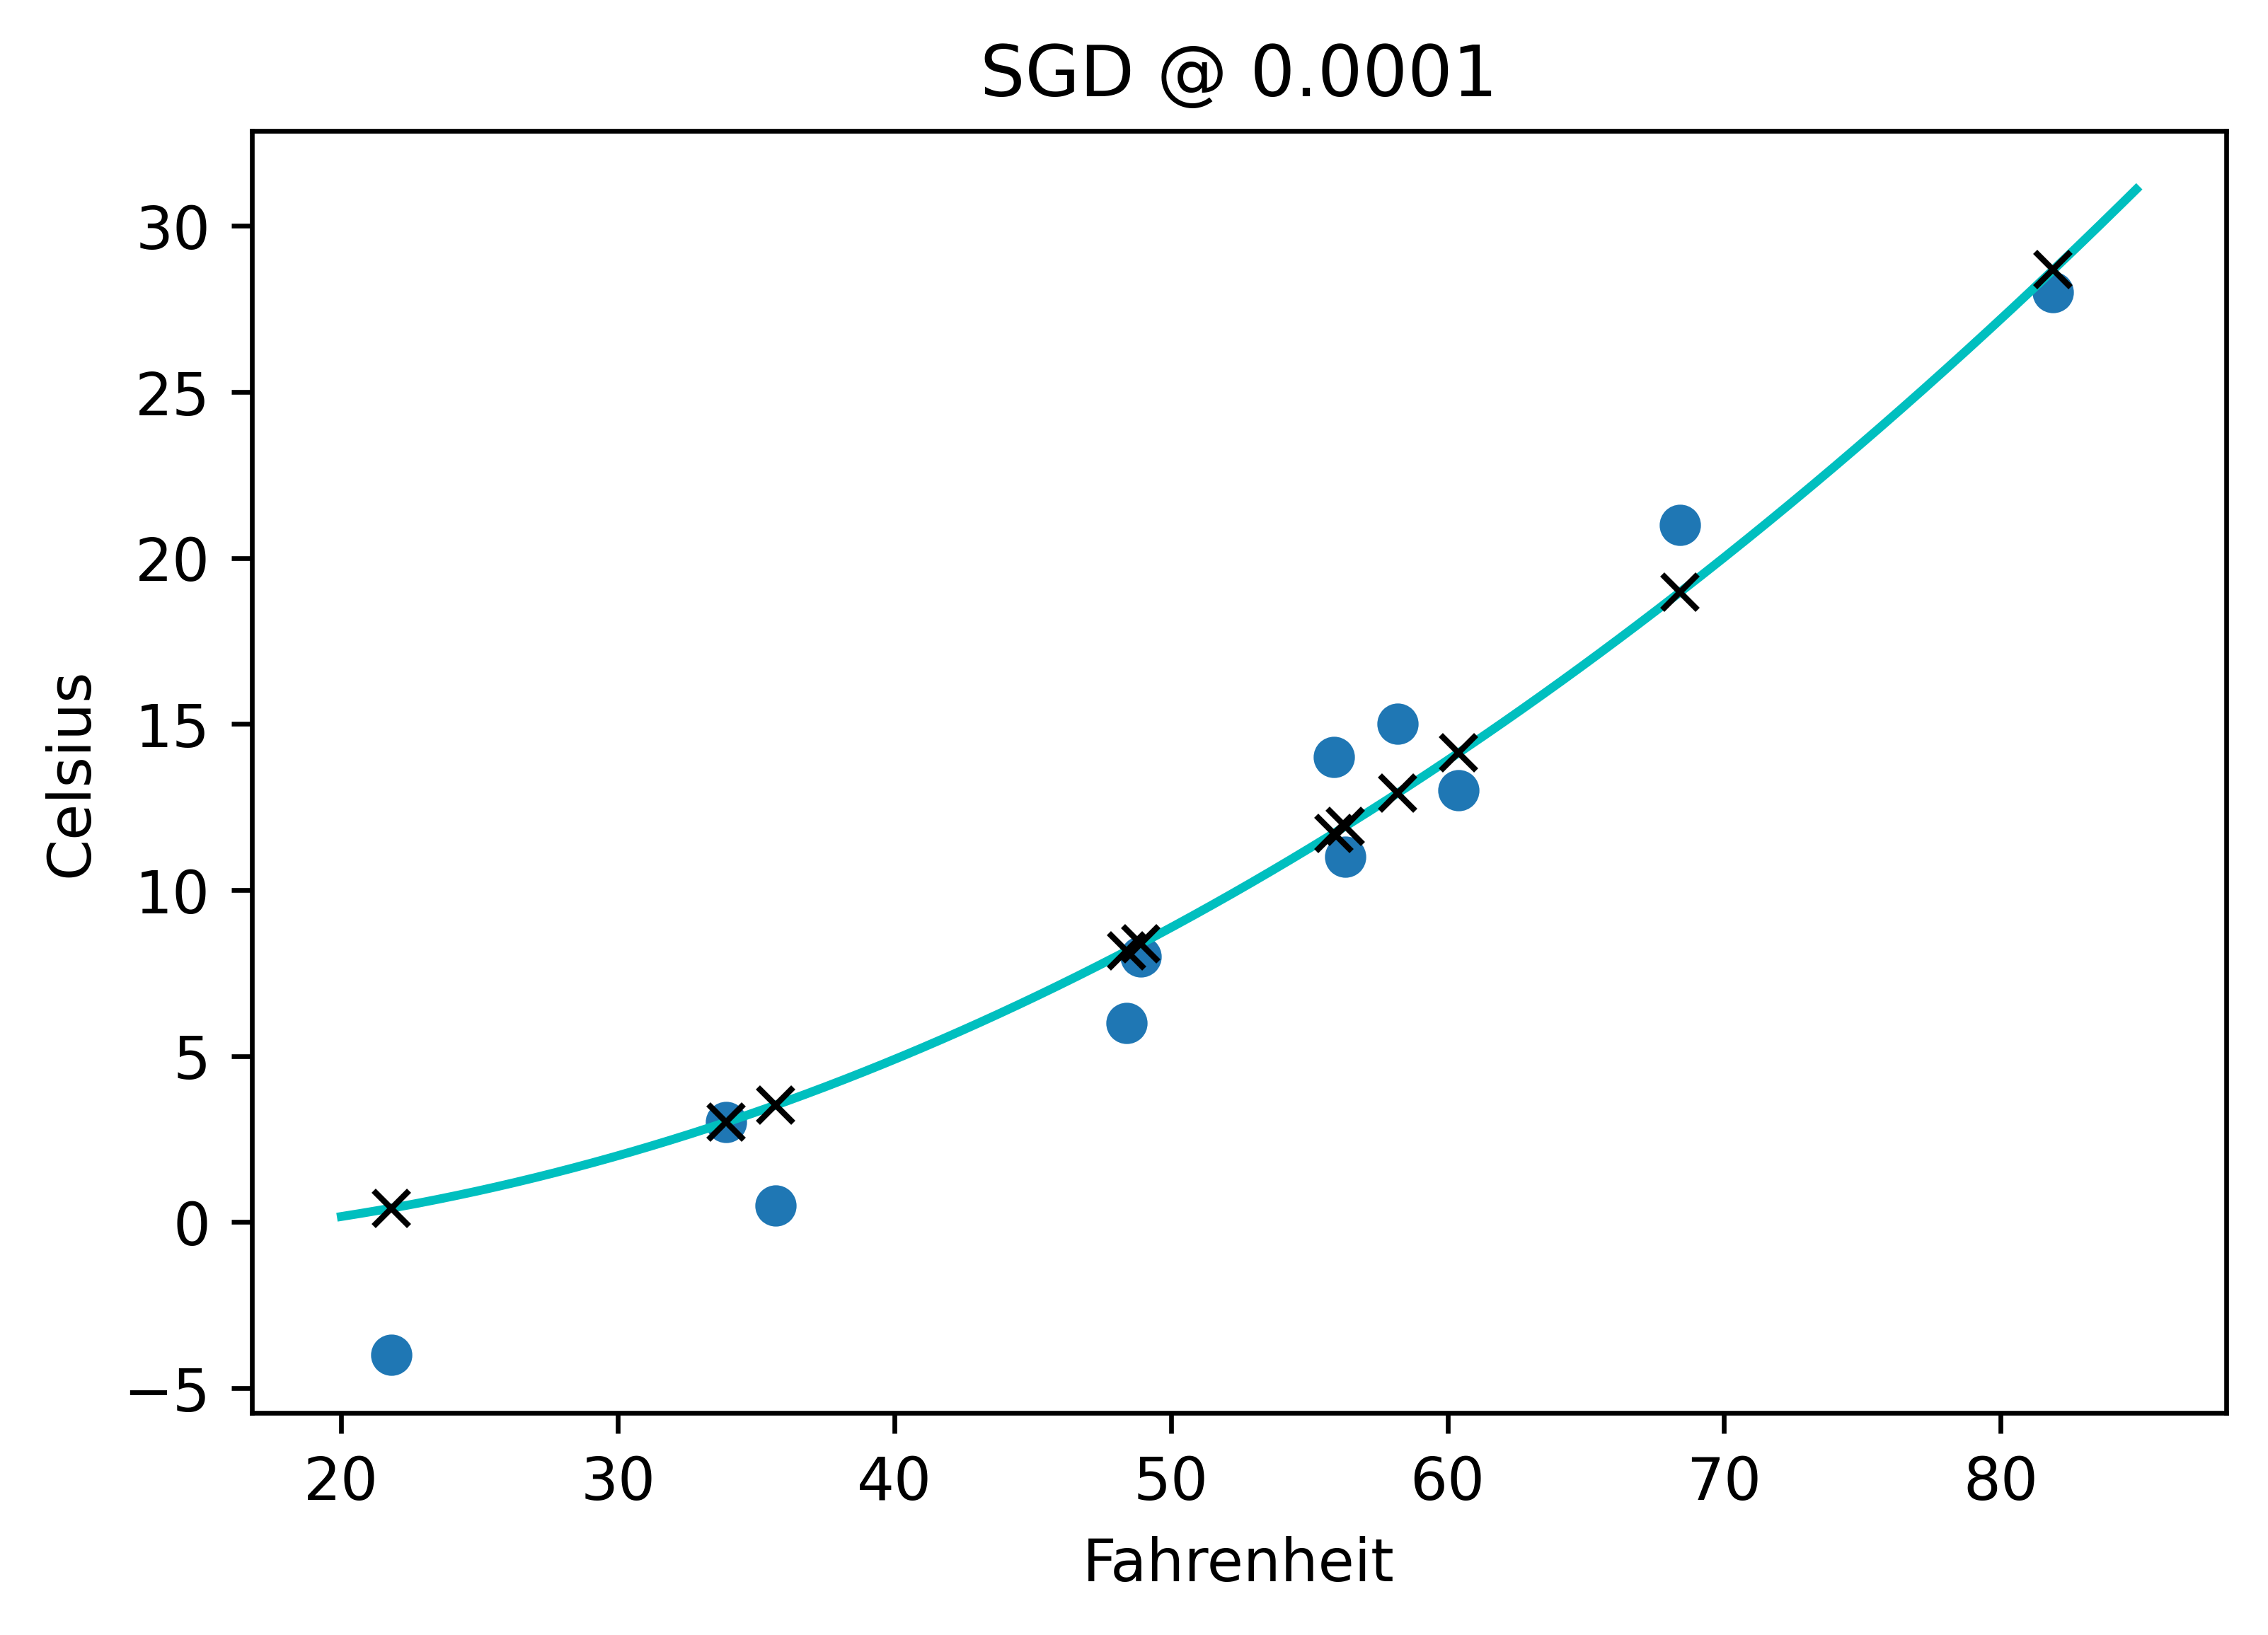

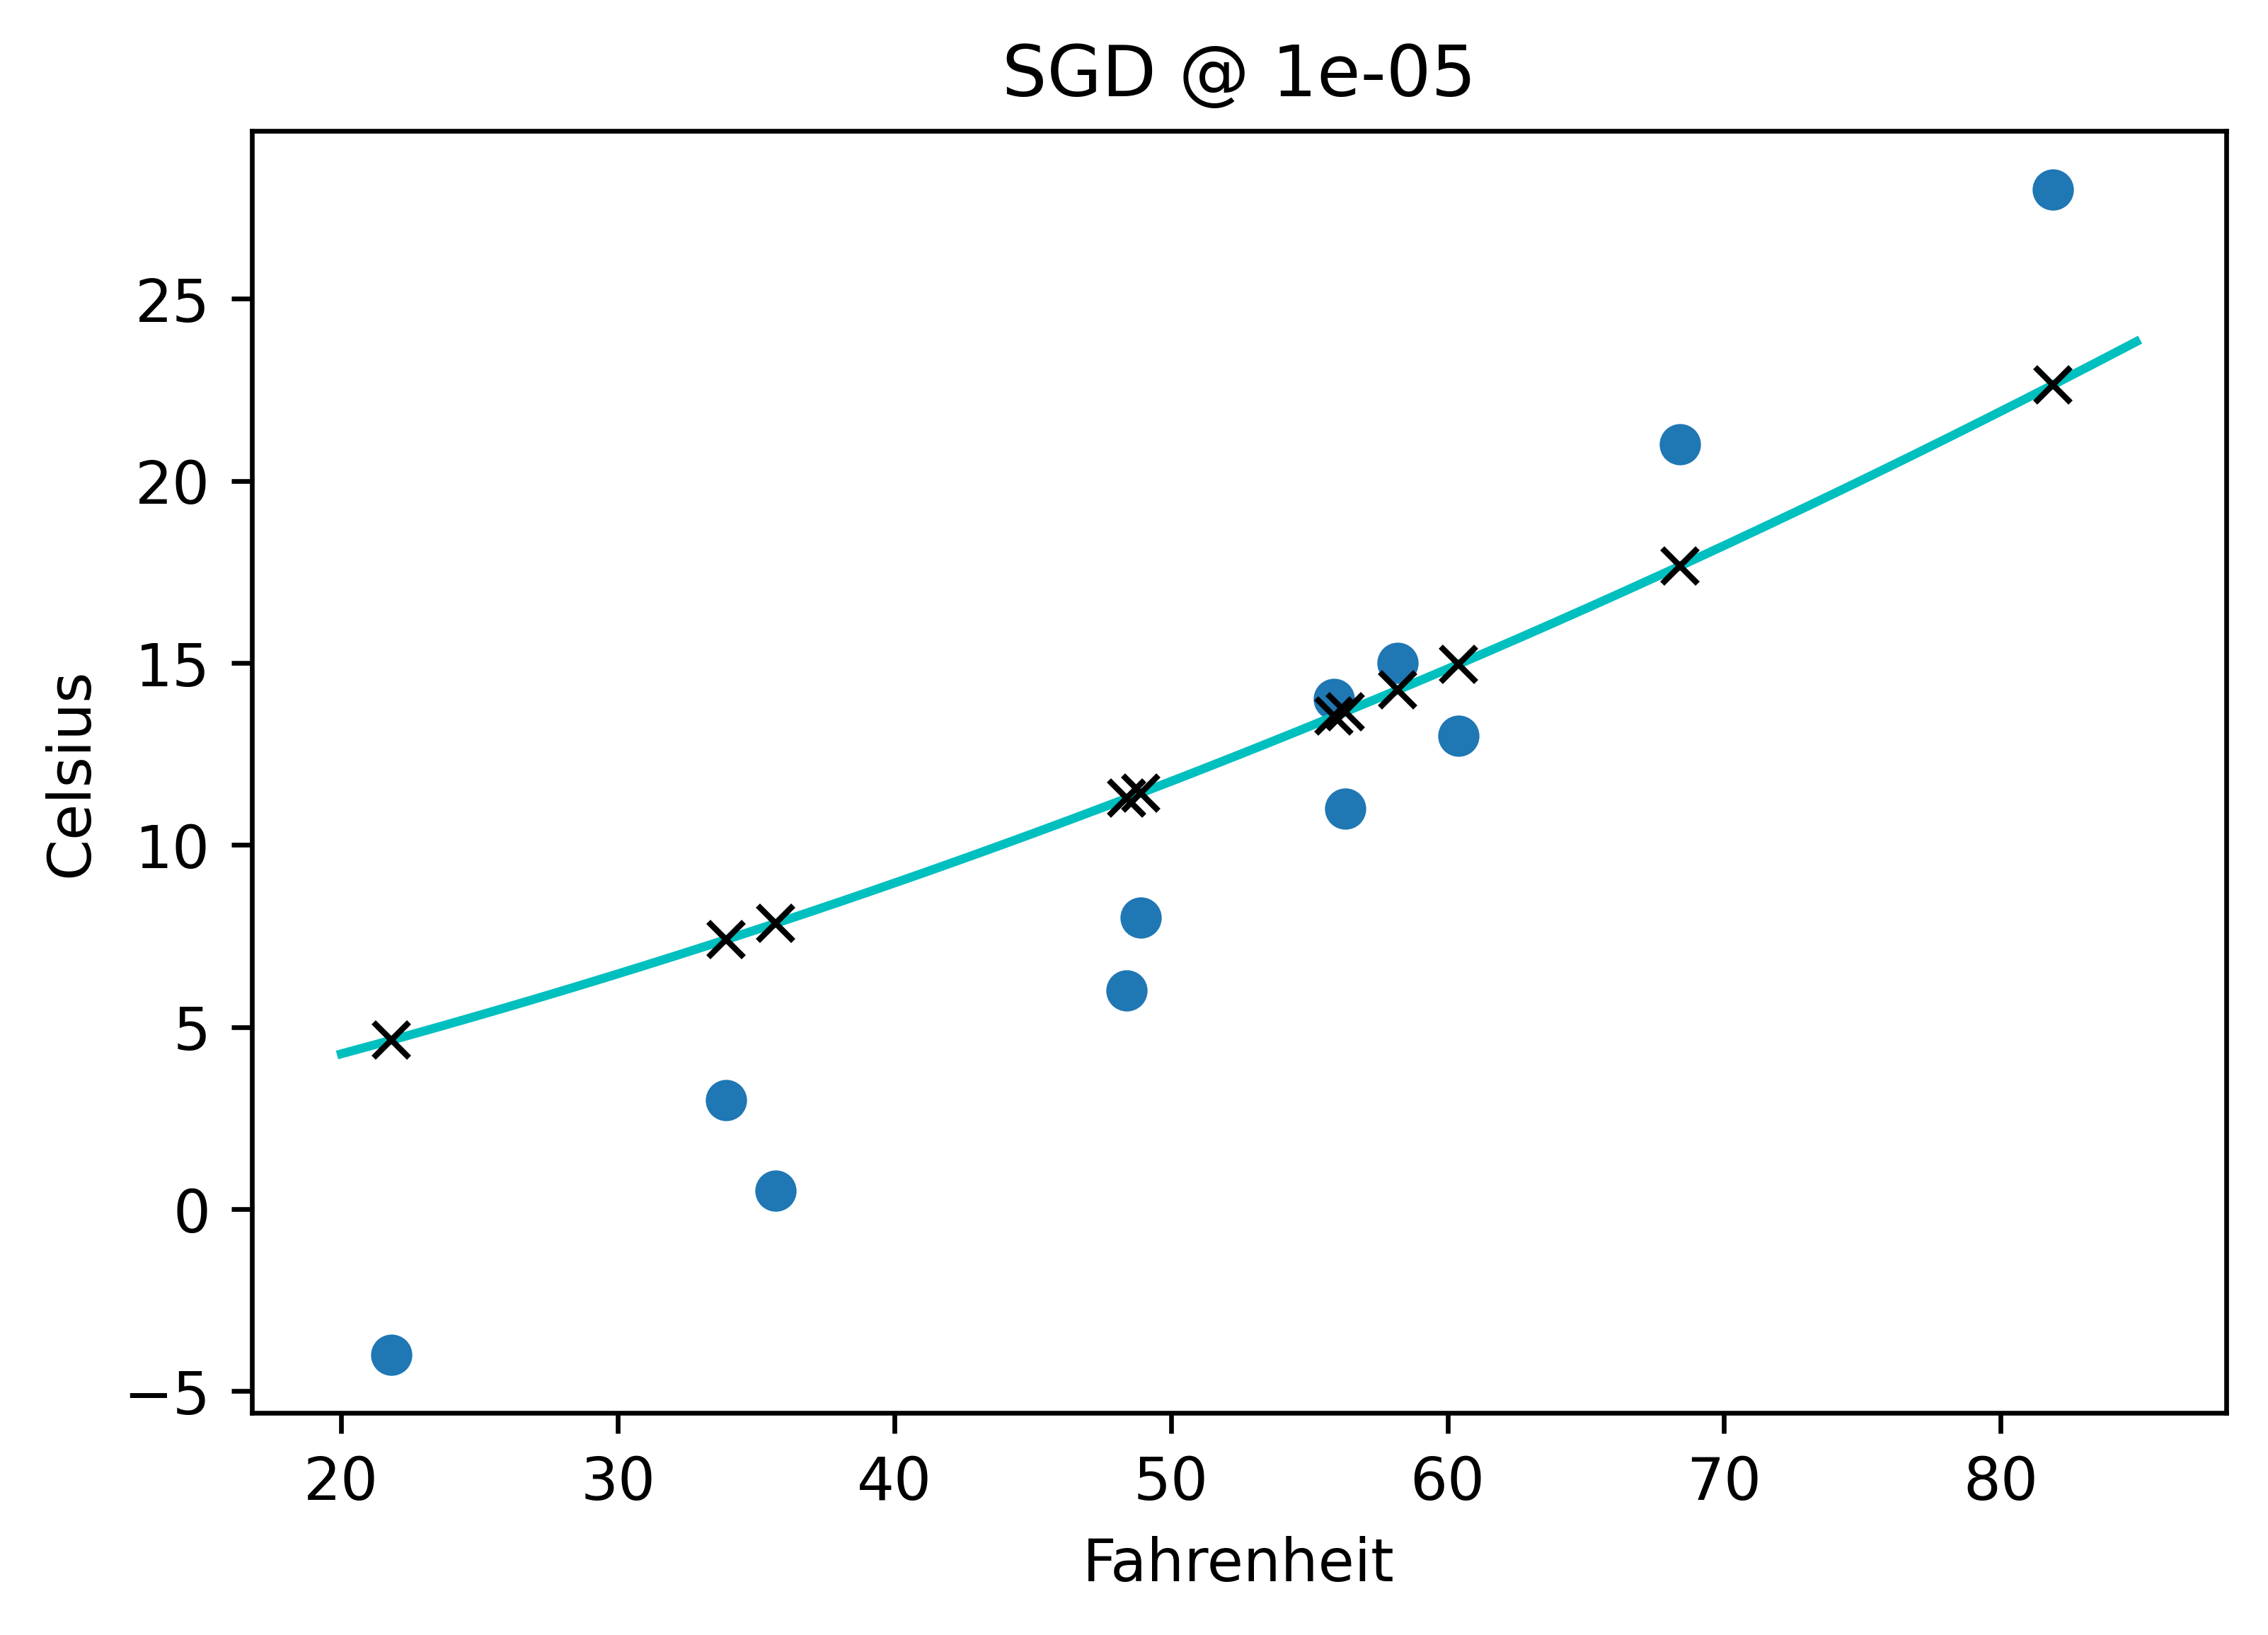

In [16]:
for rate in rates_to_learn_at:
    print(f"  Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    optimizer = optim.SGD([params], lr=rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"SGD @ {rate}")
    
    print('\n'+"--"*30+'\n')

### ADAM

Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 2.3122005462646484
    Epoch 1000, Loss 2.1011149883270264
    Epoch 1500, Loss 2.1074178218841553
    Epoch 2000, Loss 2.090721368789673
    Epoch 2500, Loss 2.0907225608825684
    Epoch 3000, Loss 2.090721368789673
    Epoch 3500, Loss 2.097216844558716
    Epoch 4000, Loss 2.090721368789673
    Epoch 4500, Loss 2.0913264751434326
    Epoch 5000, Loss 2.090721368789673
Final Paramaters: tensor([  0.2830,   2.4760, -10.6496], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 3.327059030532837
    Epoch 1000, Loss 3.0957894325256348
    Epoch 1500, Loss 2.923596143722534
    Epoch 2000, Loss 2.7324066162109375
    Epoch 2500, Loss 2.545511484146118
    Epoch 3000, Loss 2.381272315979004
    Epoch 3500, Loss 2.2538251876831055
    Epoch 4000, Loss 2.1685006618499756
    Epoch 4500, Loss 2.120863914489746
   

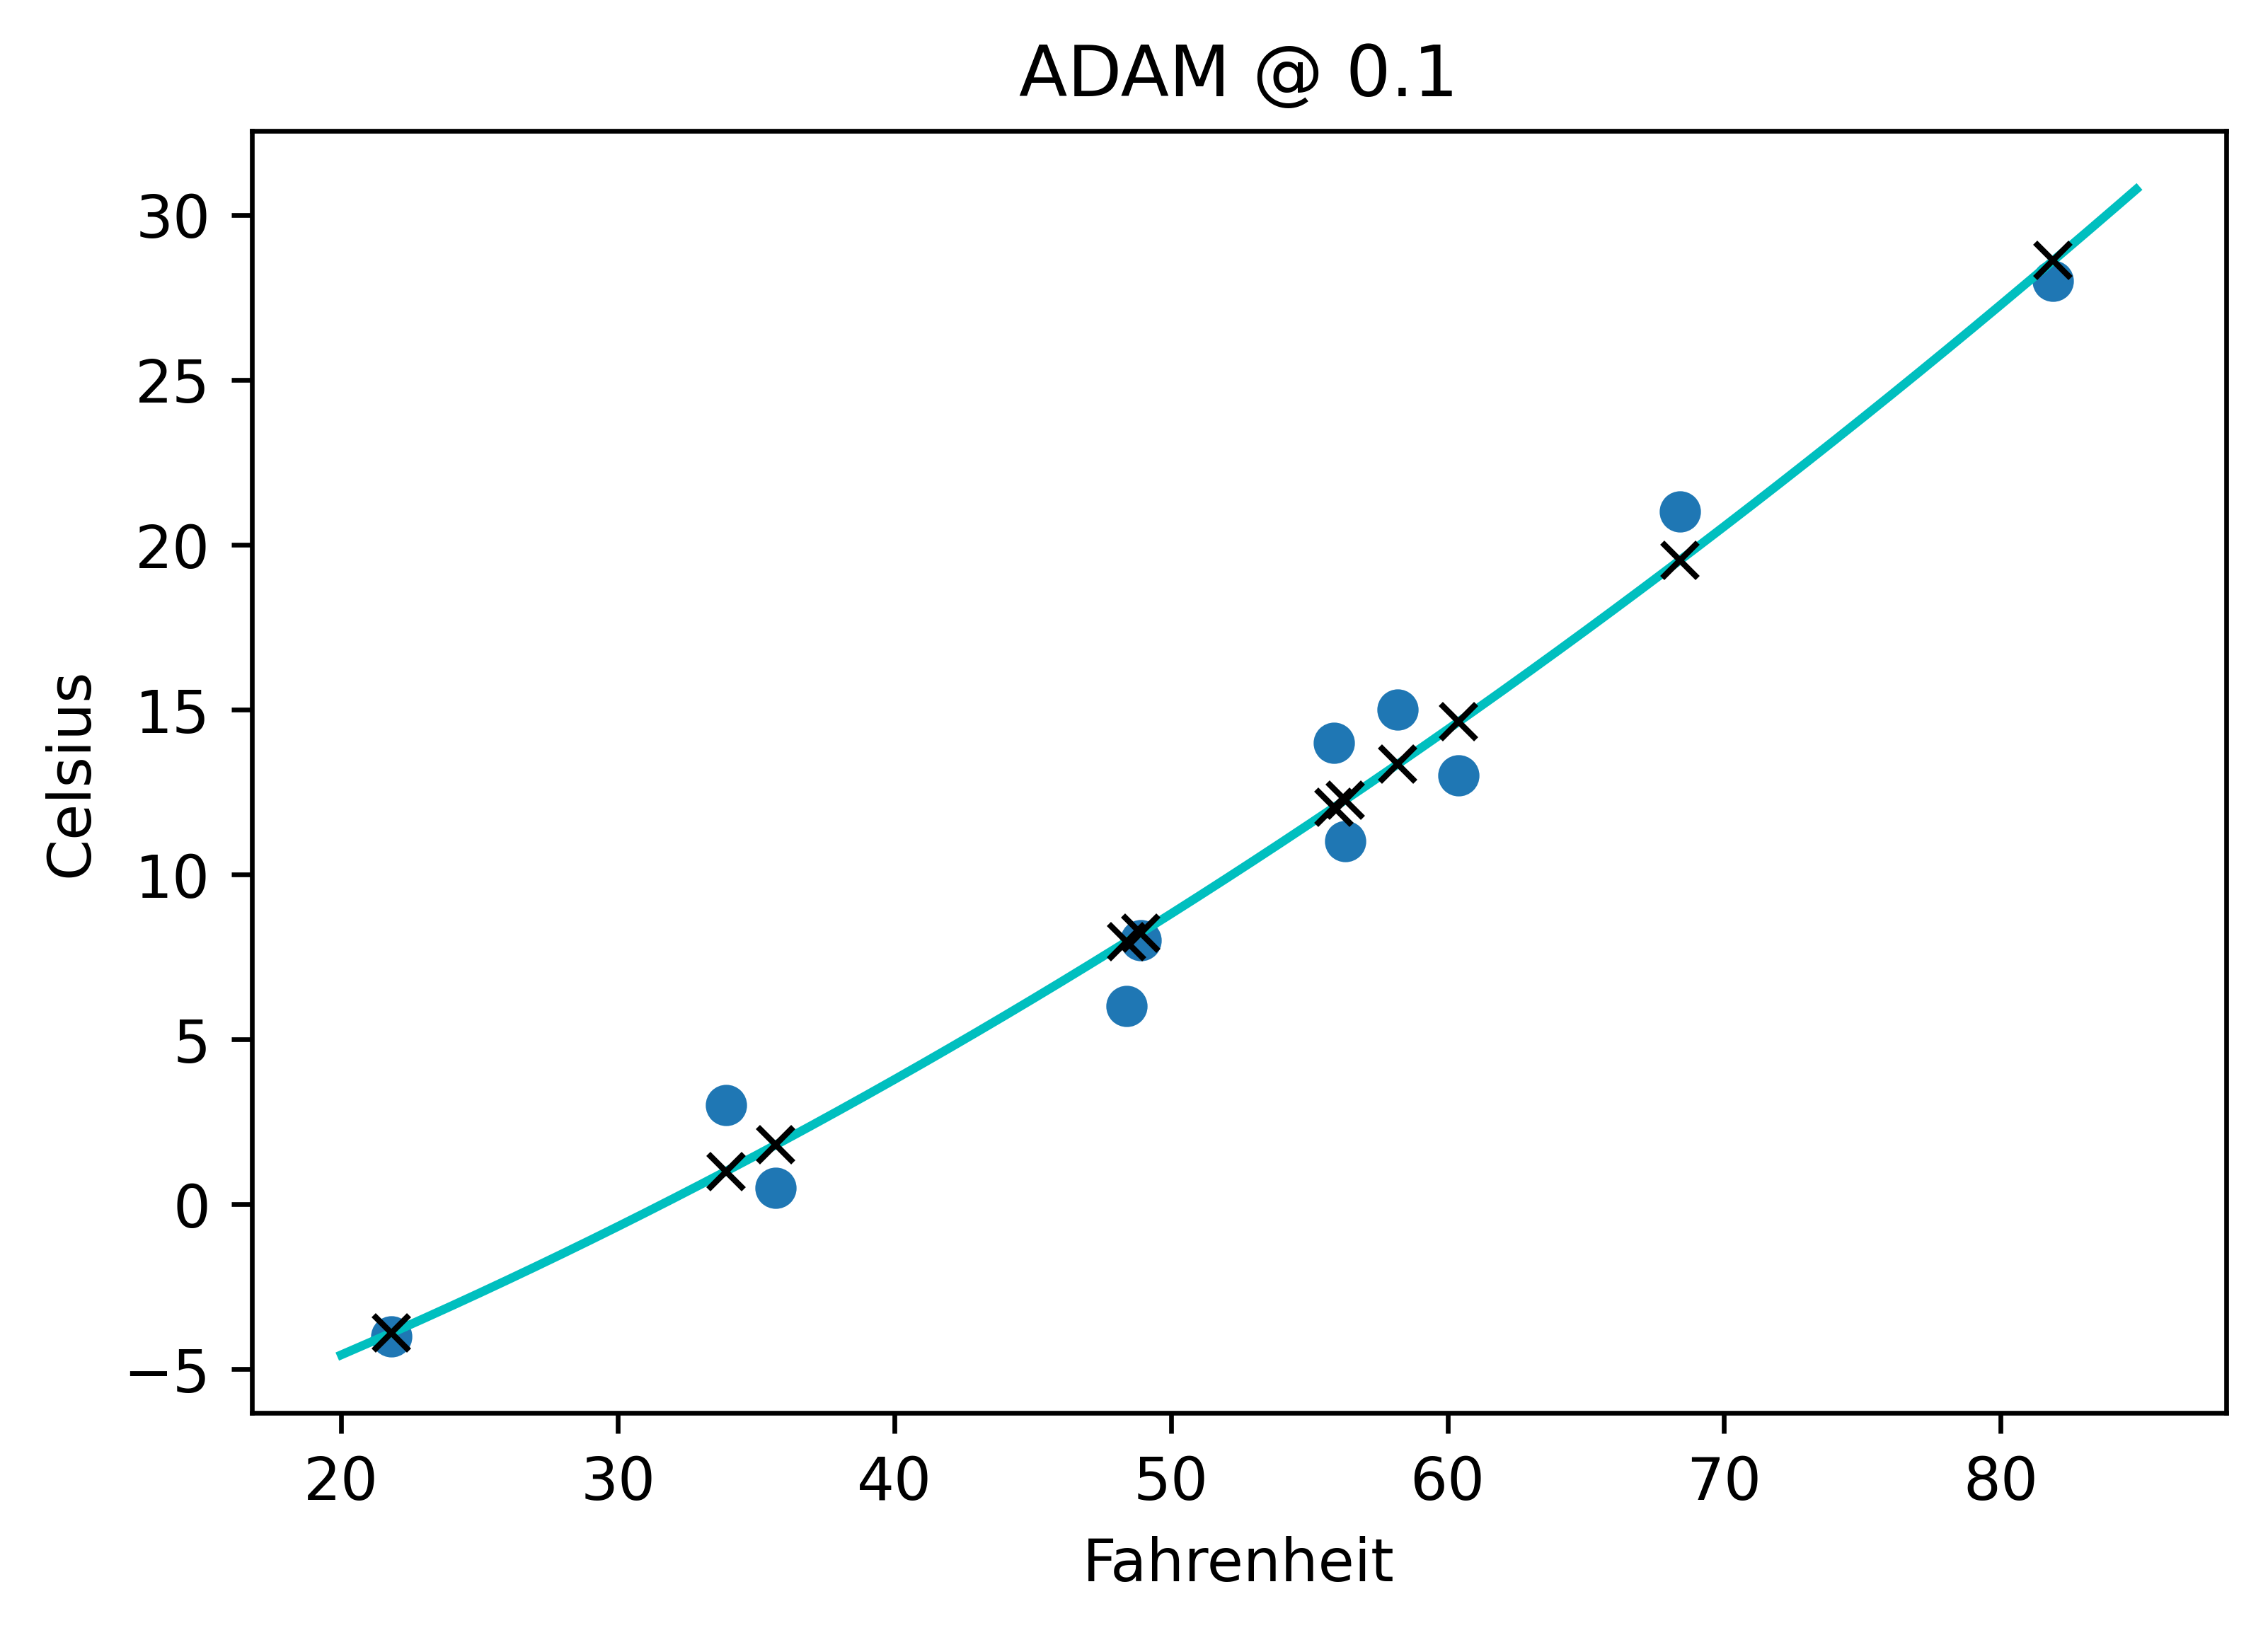

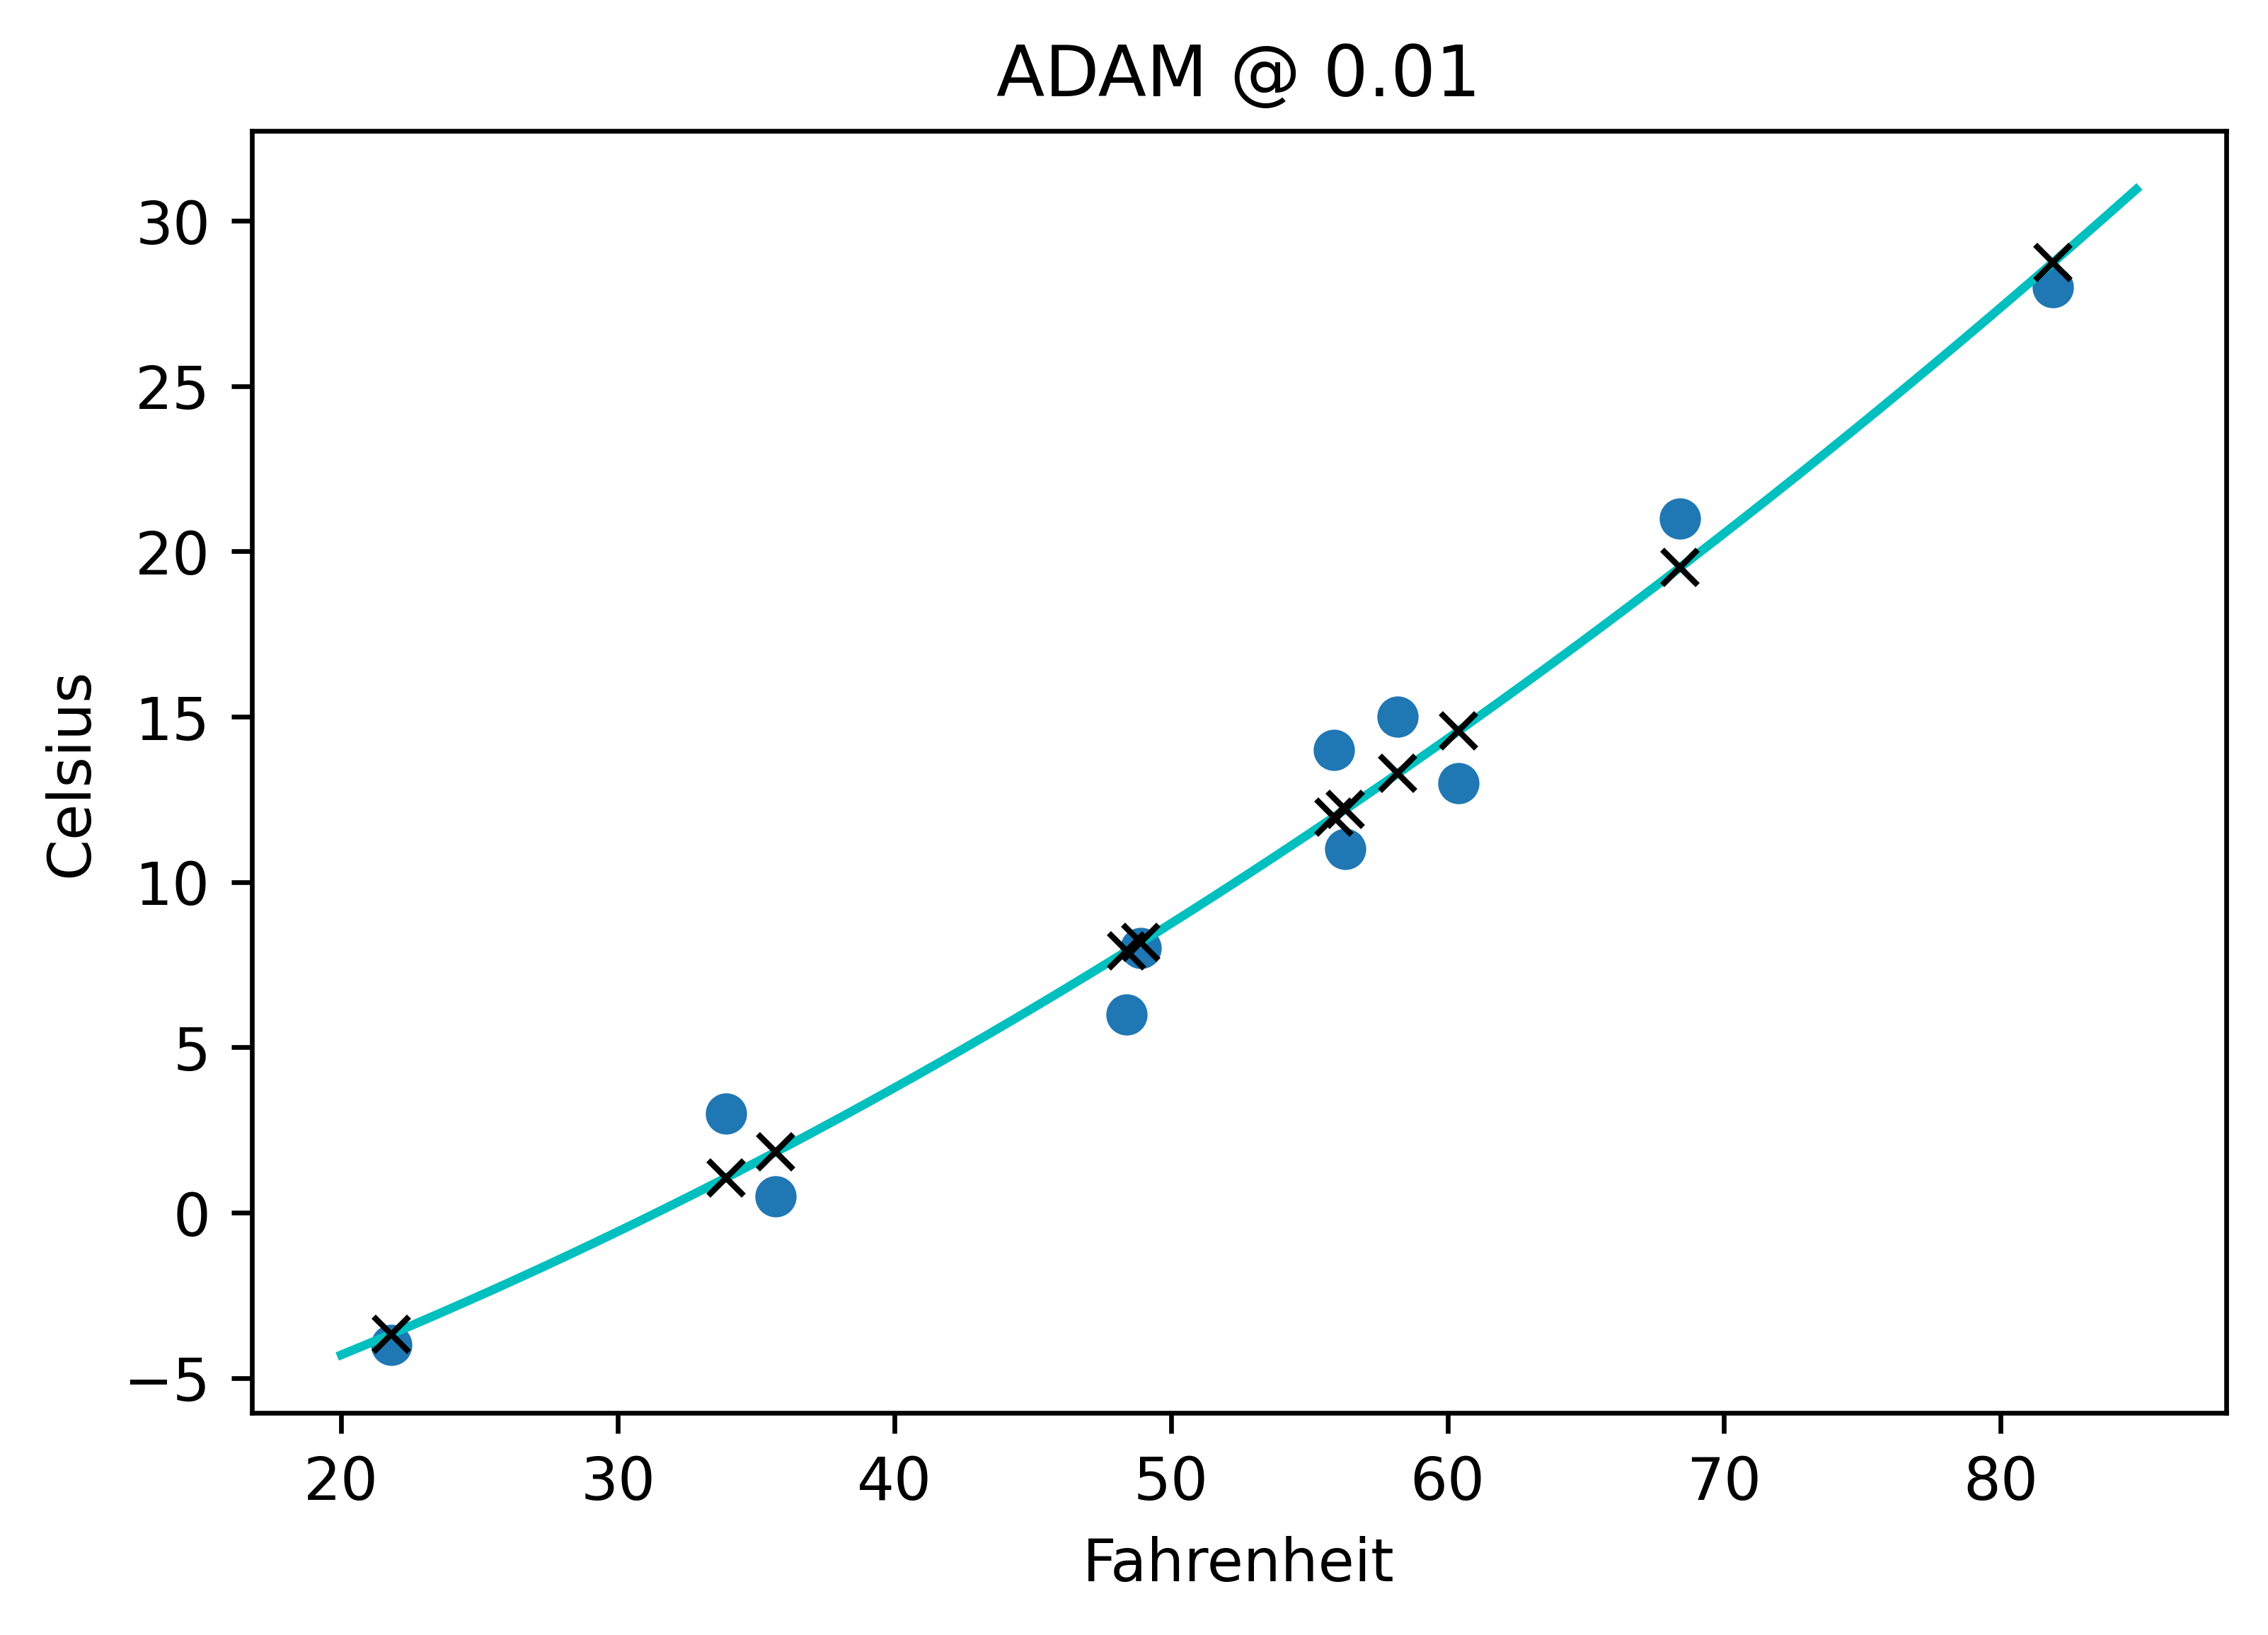

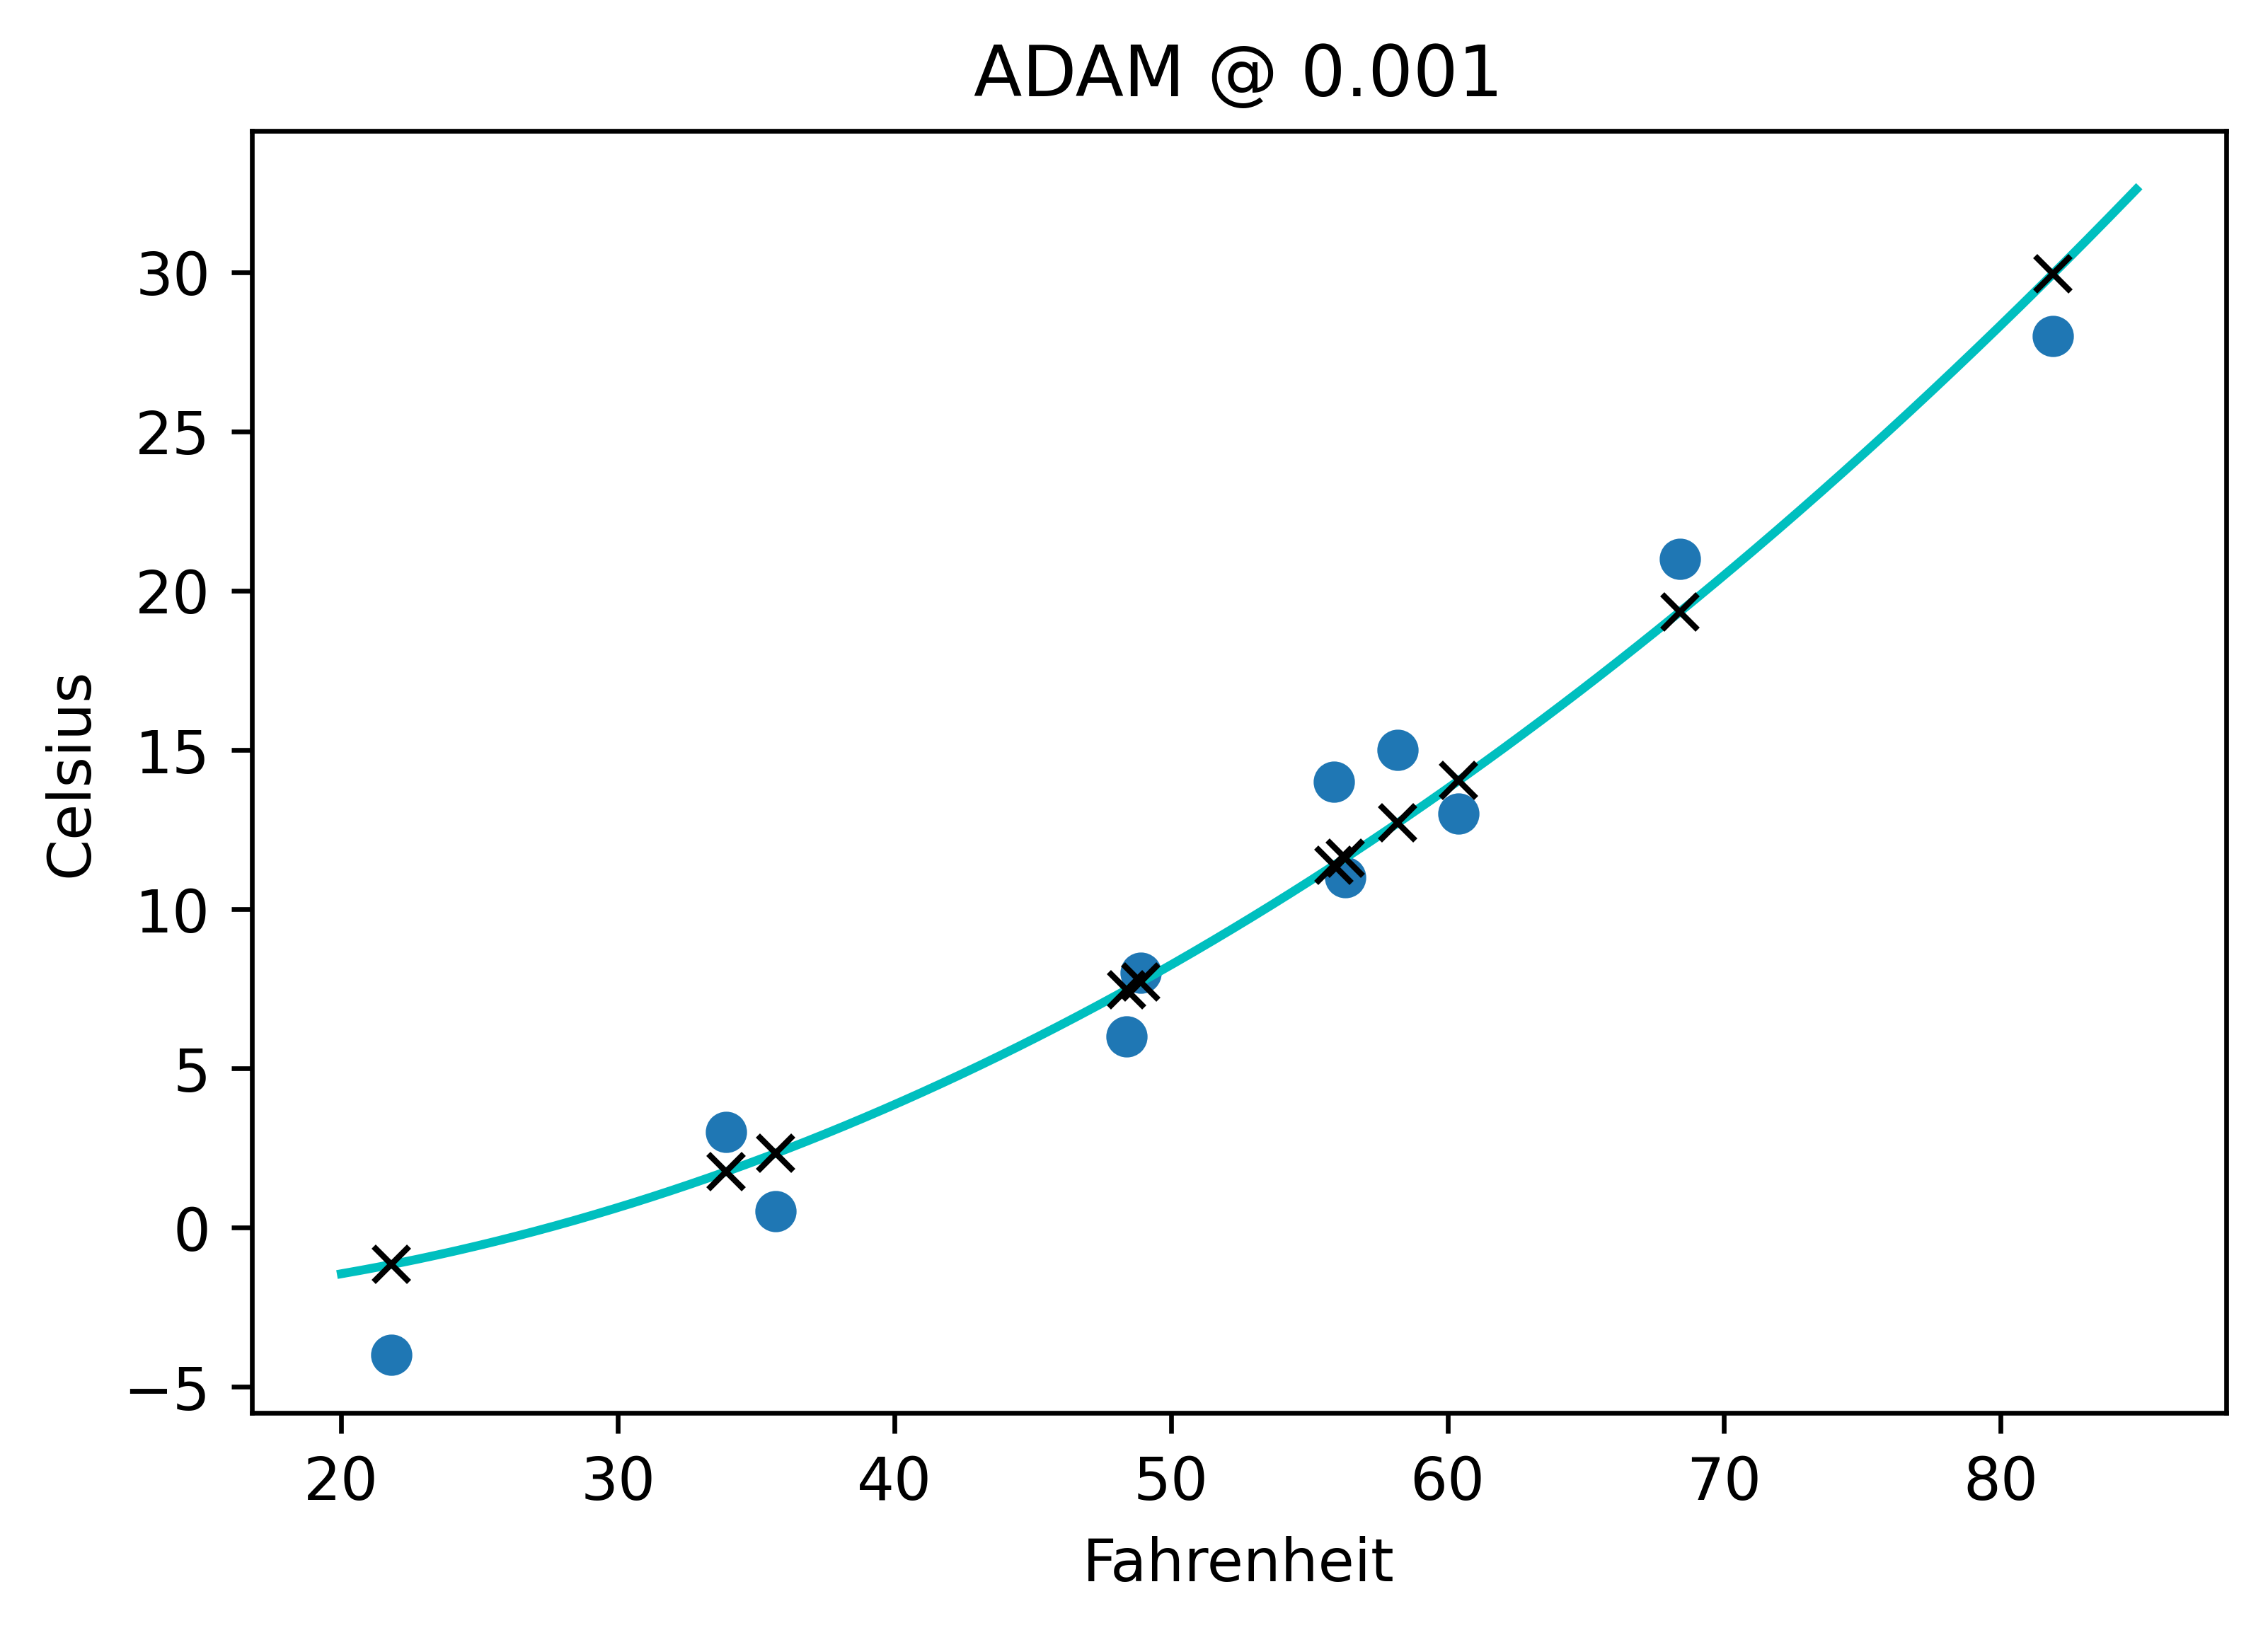

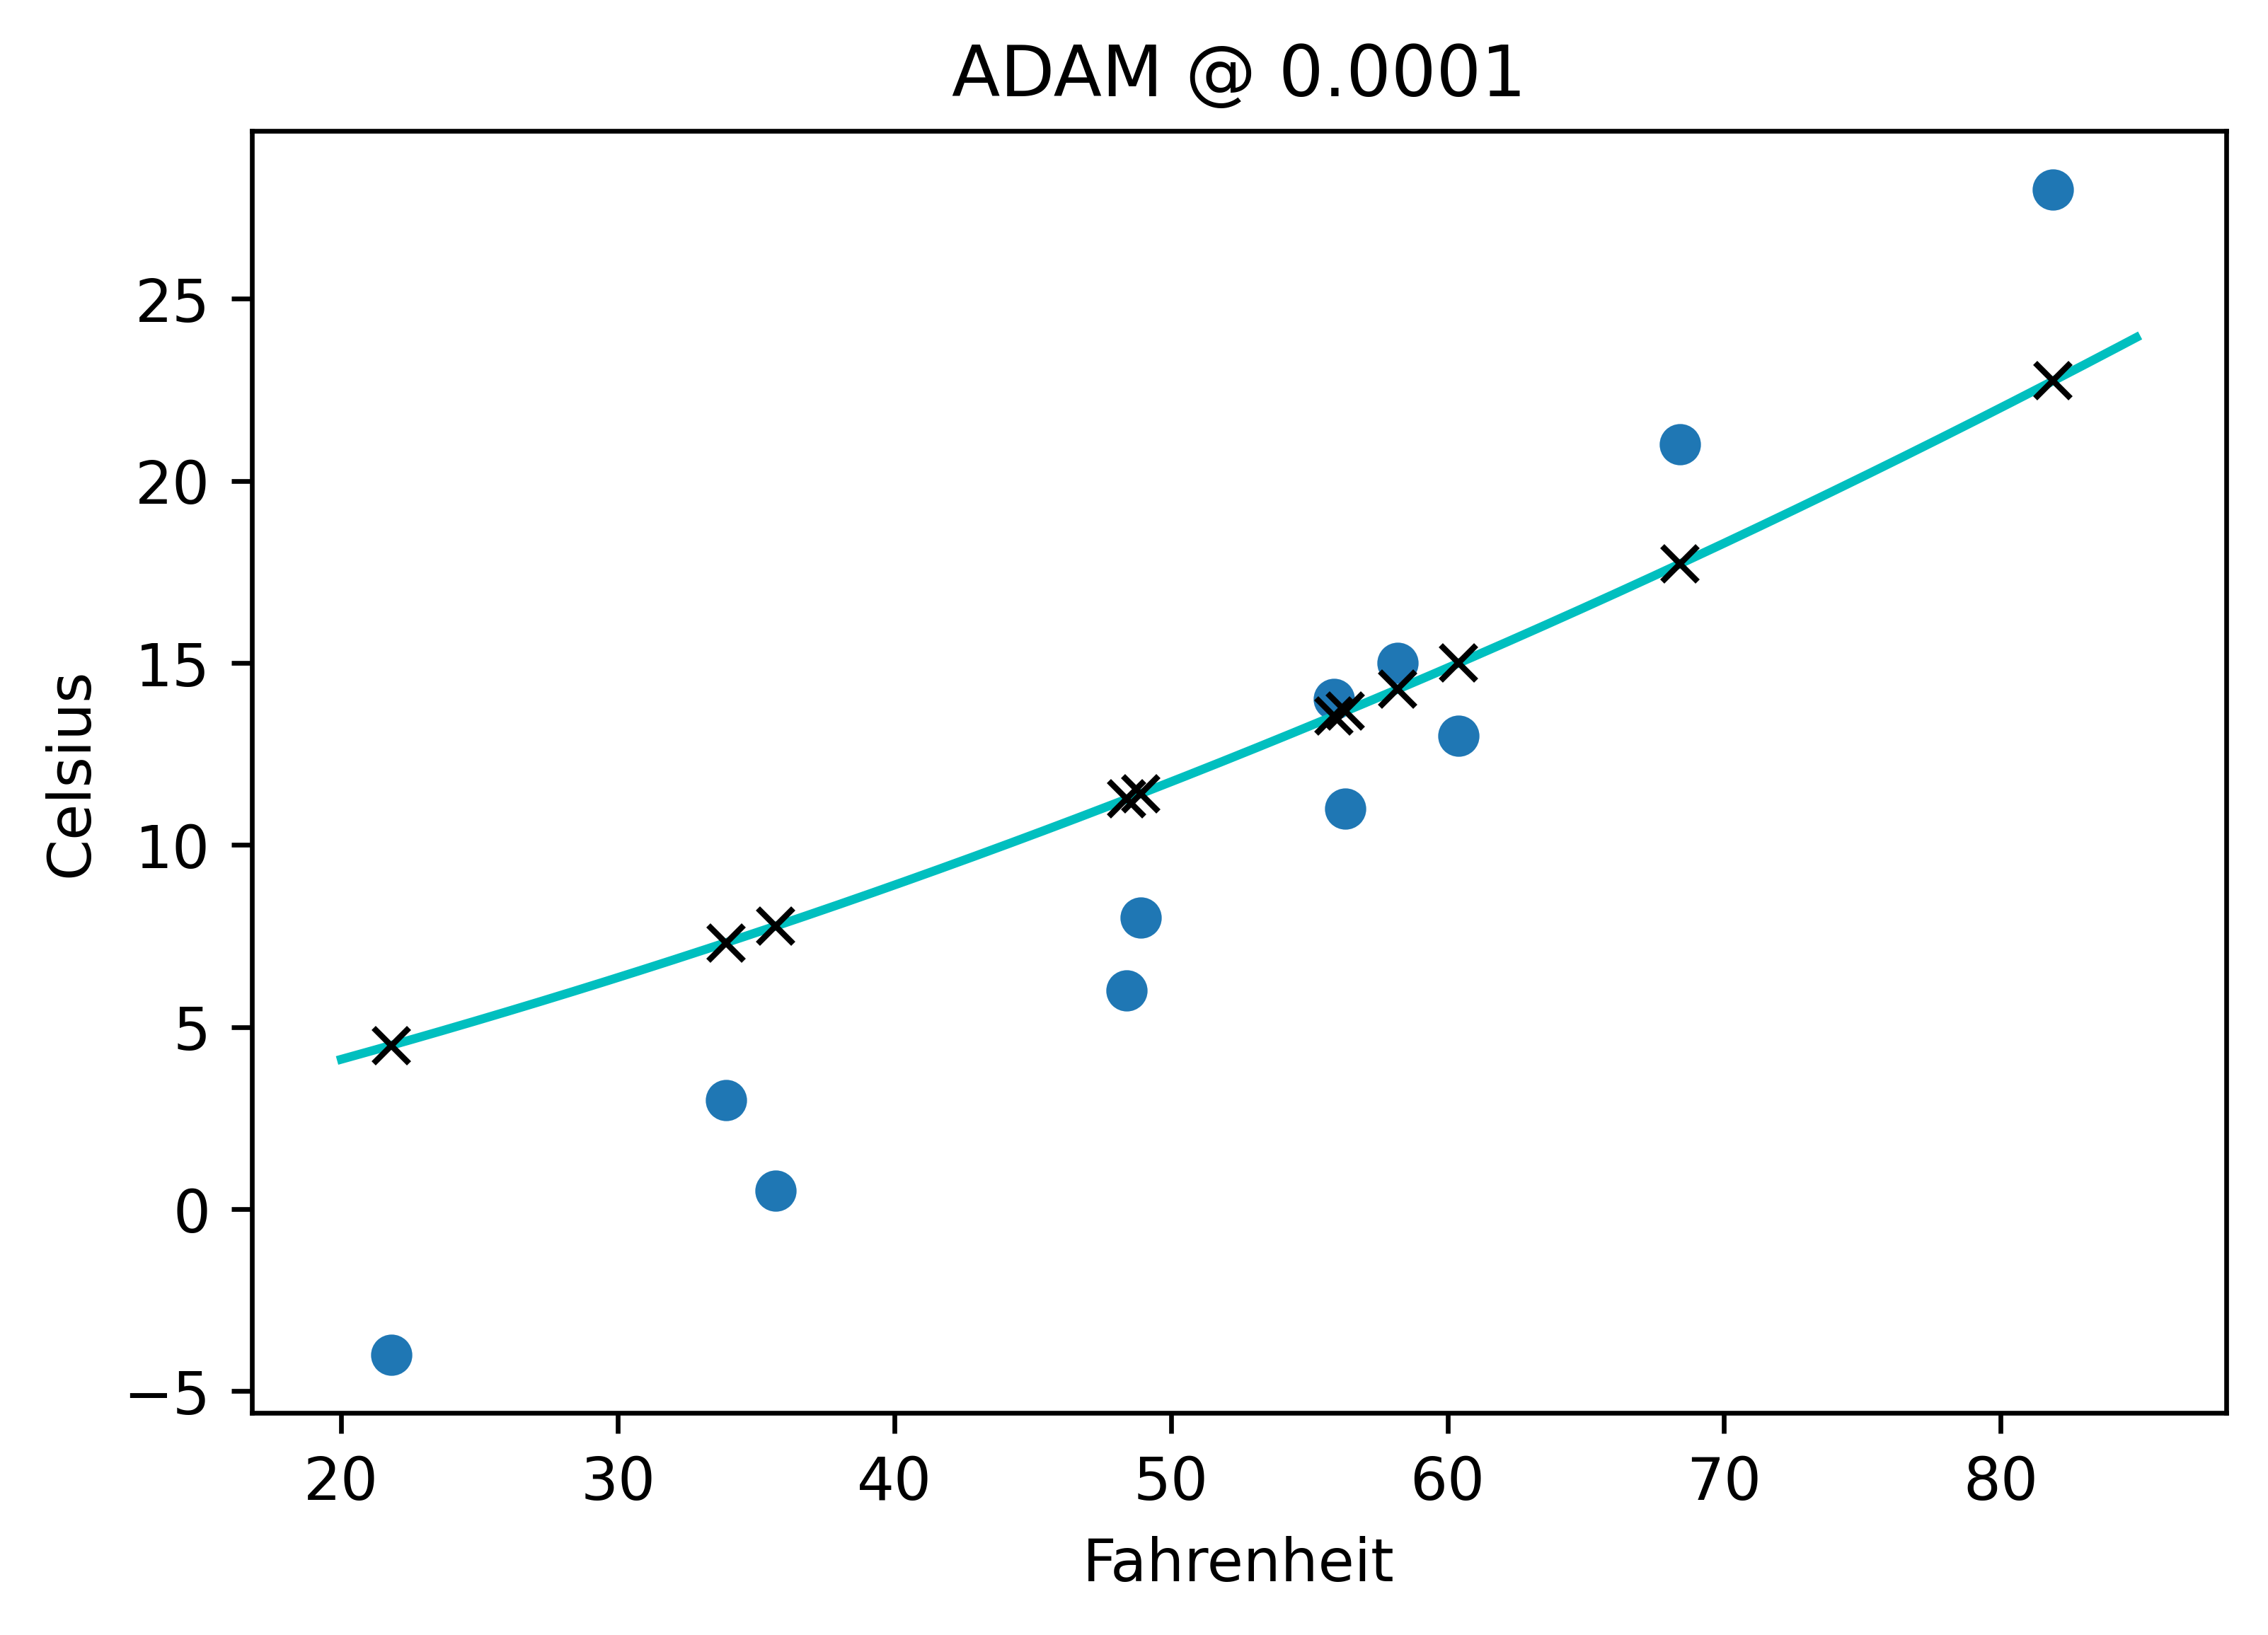

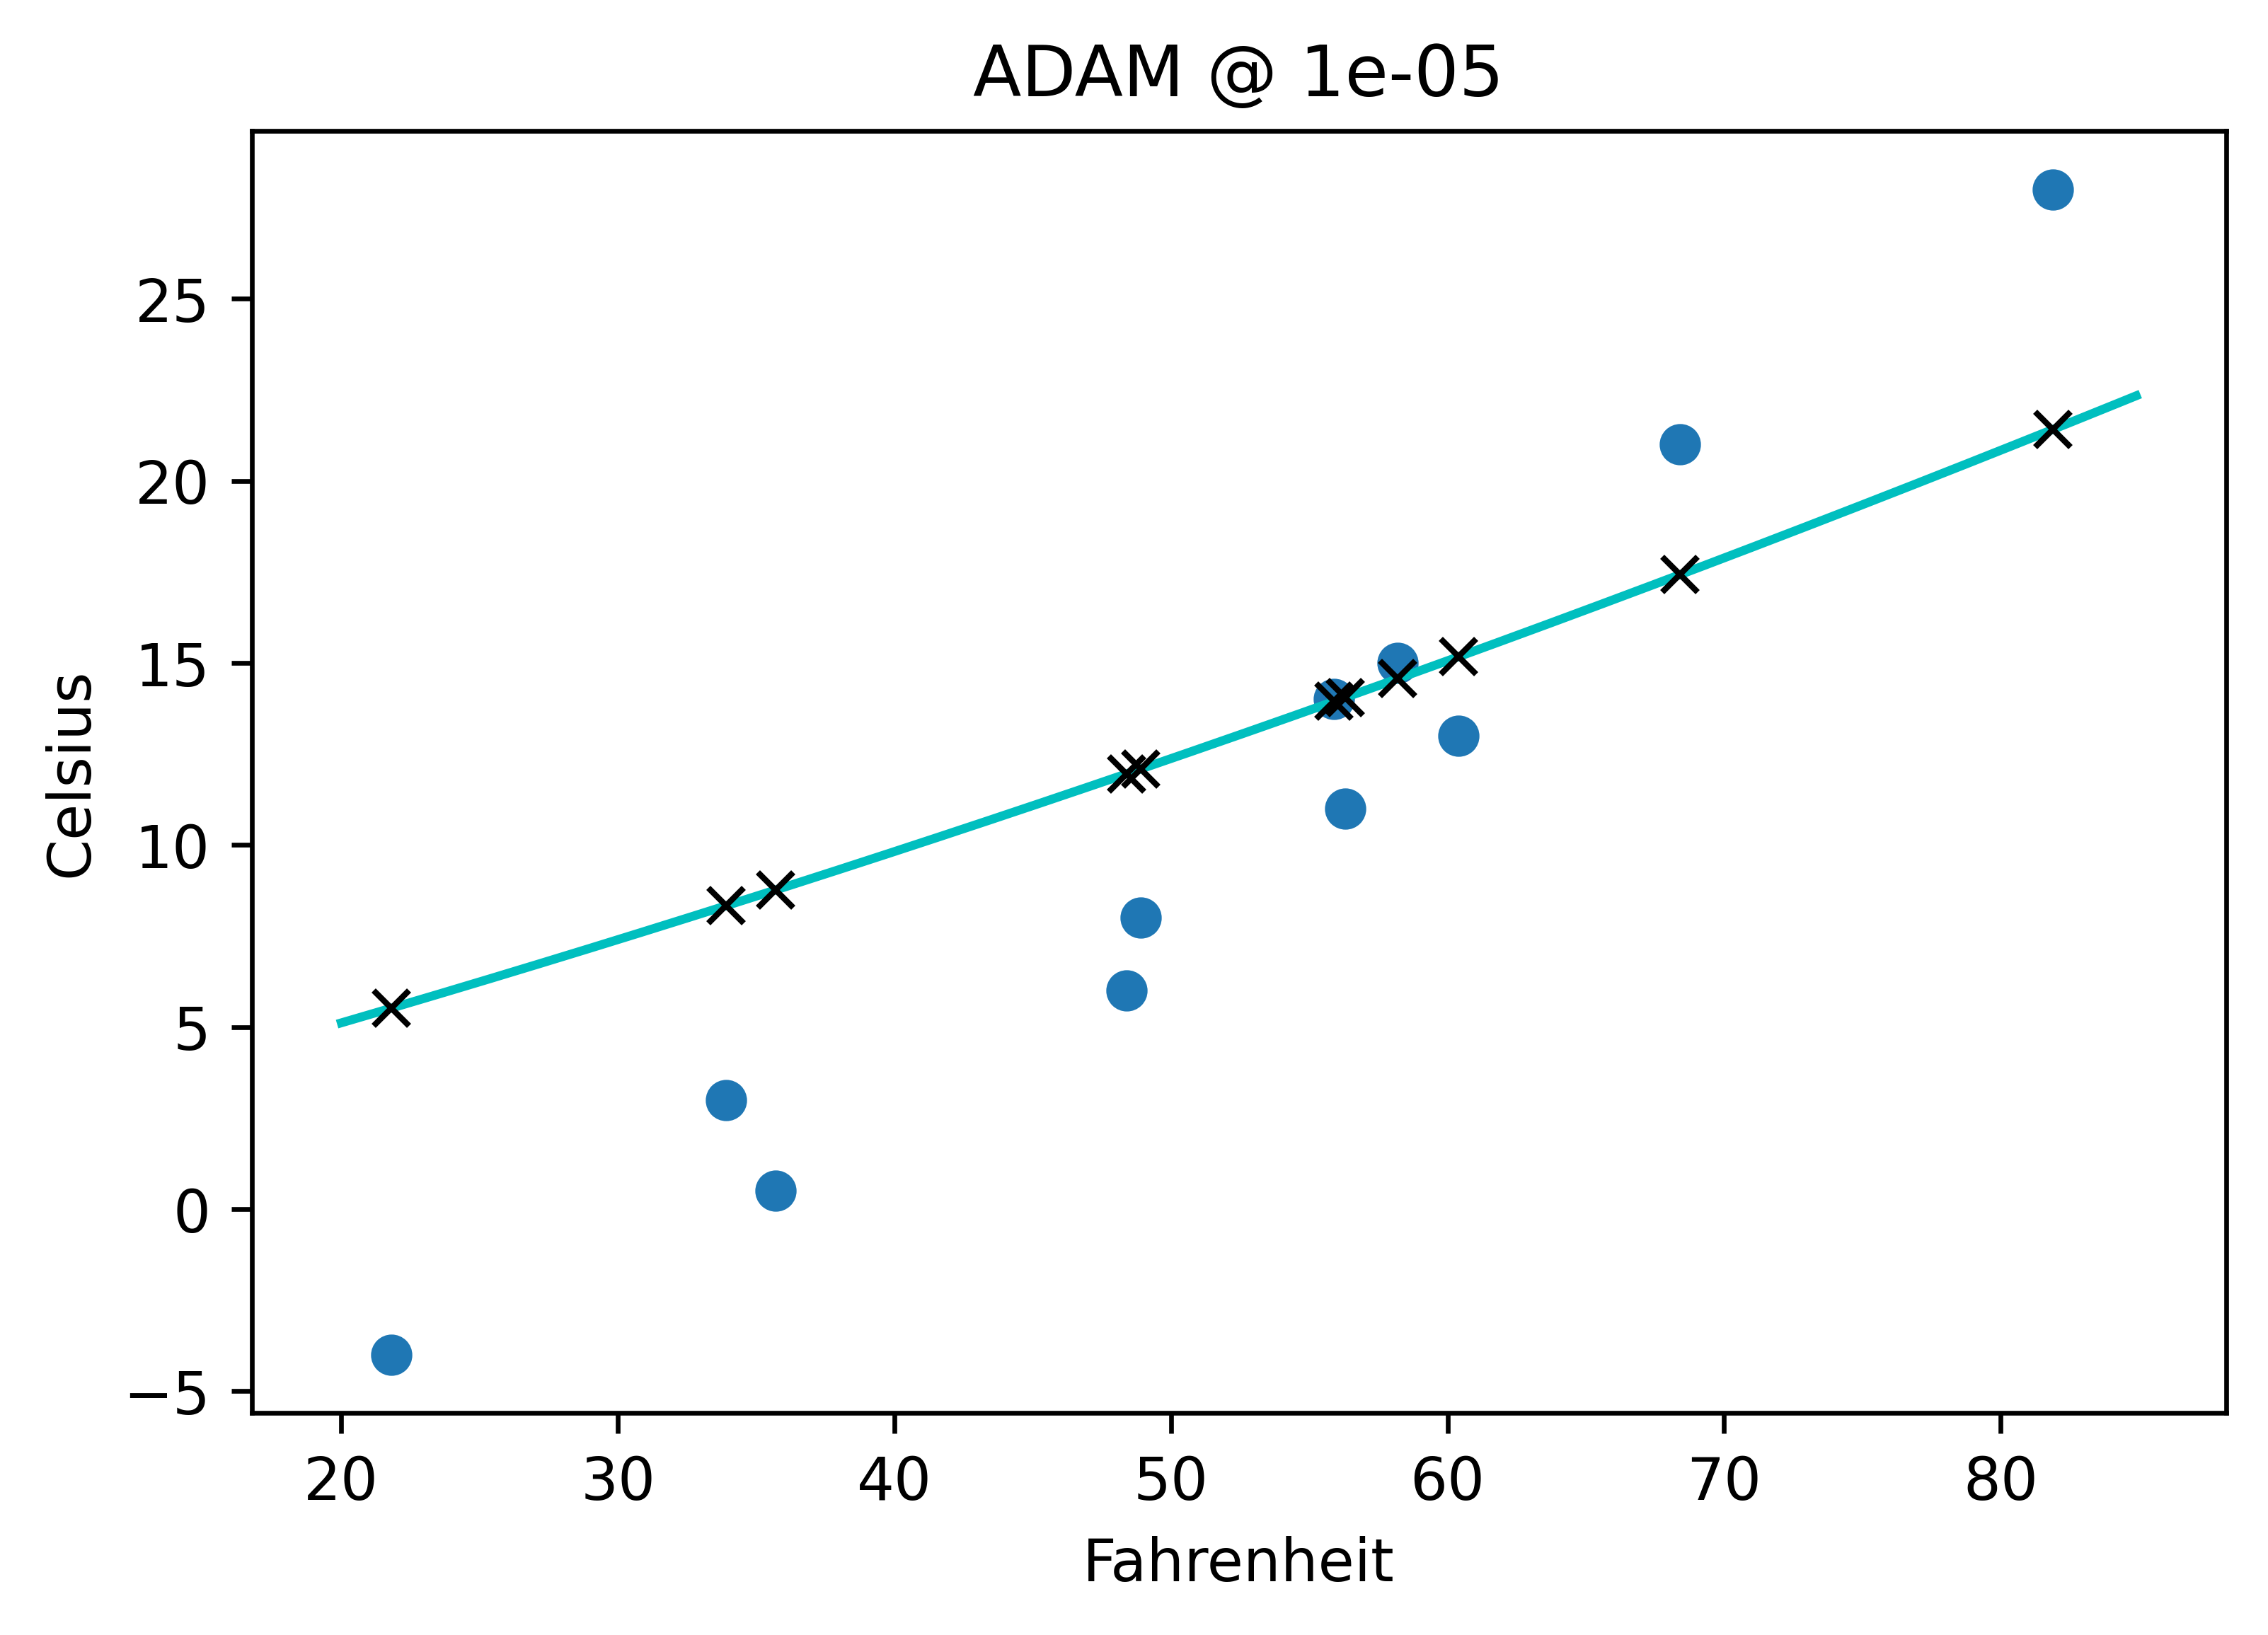

In [17]:
for rate in rates_to_learn_at:
    print(f"Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.Adam([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"ADAM @ {rate}")
    
    print('\n'+"--"*30+'\n')

### ADAGRAD

Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 3.5323750972747803
    Epoch 1000, Loss 3.153088331222534
    Epoch 1500, Loss 3.0957770347595215
    Epoch 2000, Loss 3.0496177673339844
    Epoch 2500, Loss 3.0059127807617188
    Epoch 3000, Loss 2.9643051624298096
    Epoch 3500, Loss 2.9246842861175537
    Epoch 4000, Loss 2.8869407176971436
    Epoch 4500, Loss 2.850983142852783
    Epoch 5000, Loss 2.816714286804199
Final Paramaters: tensor([ 0.5288, -0.2203, -3.8306], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss 22.189430236816406
    Epoch 1000, Loss 19.695493698120117
    Epoch 1500, Loss 17.944202423095703
    Epoch 2000, Loss 16.573047637939453
    Epoch 2500, Loss 15.442191123962402
    Epoch 3000, Loss 14.480133056640625
    Epoch 3500, Loss 13.644536972045898
    Epoch 4000, Loss 12.907891273498535
    Epoch 4500, Loss 12.251145362854004

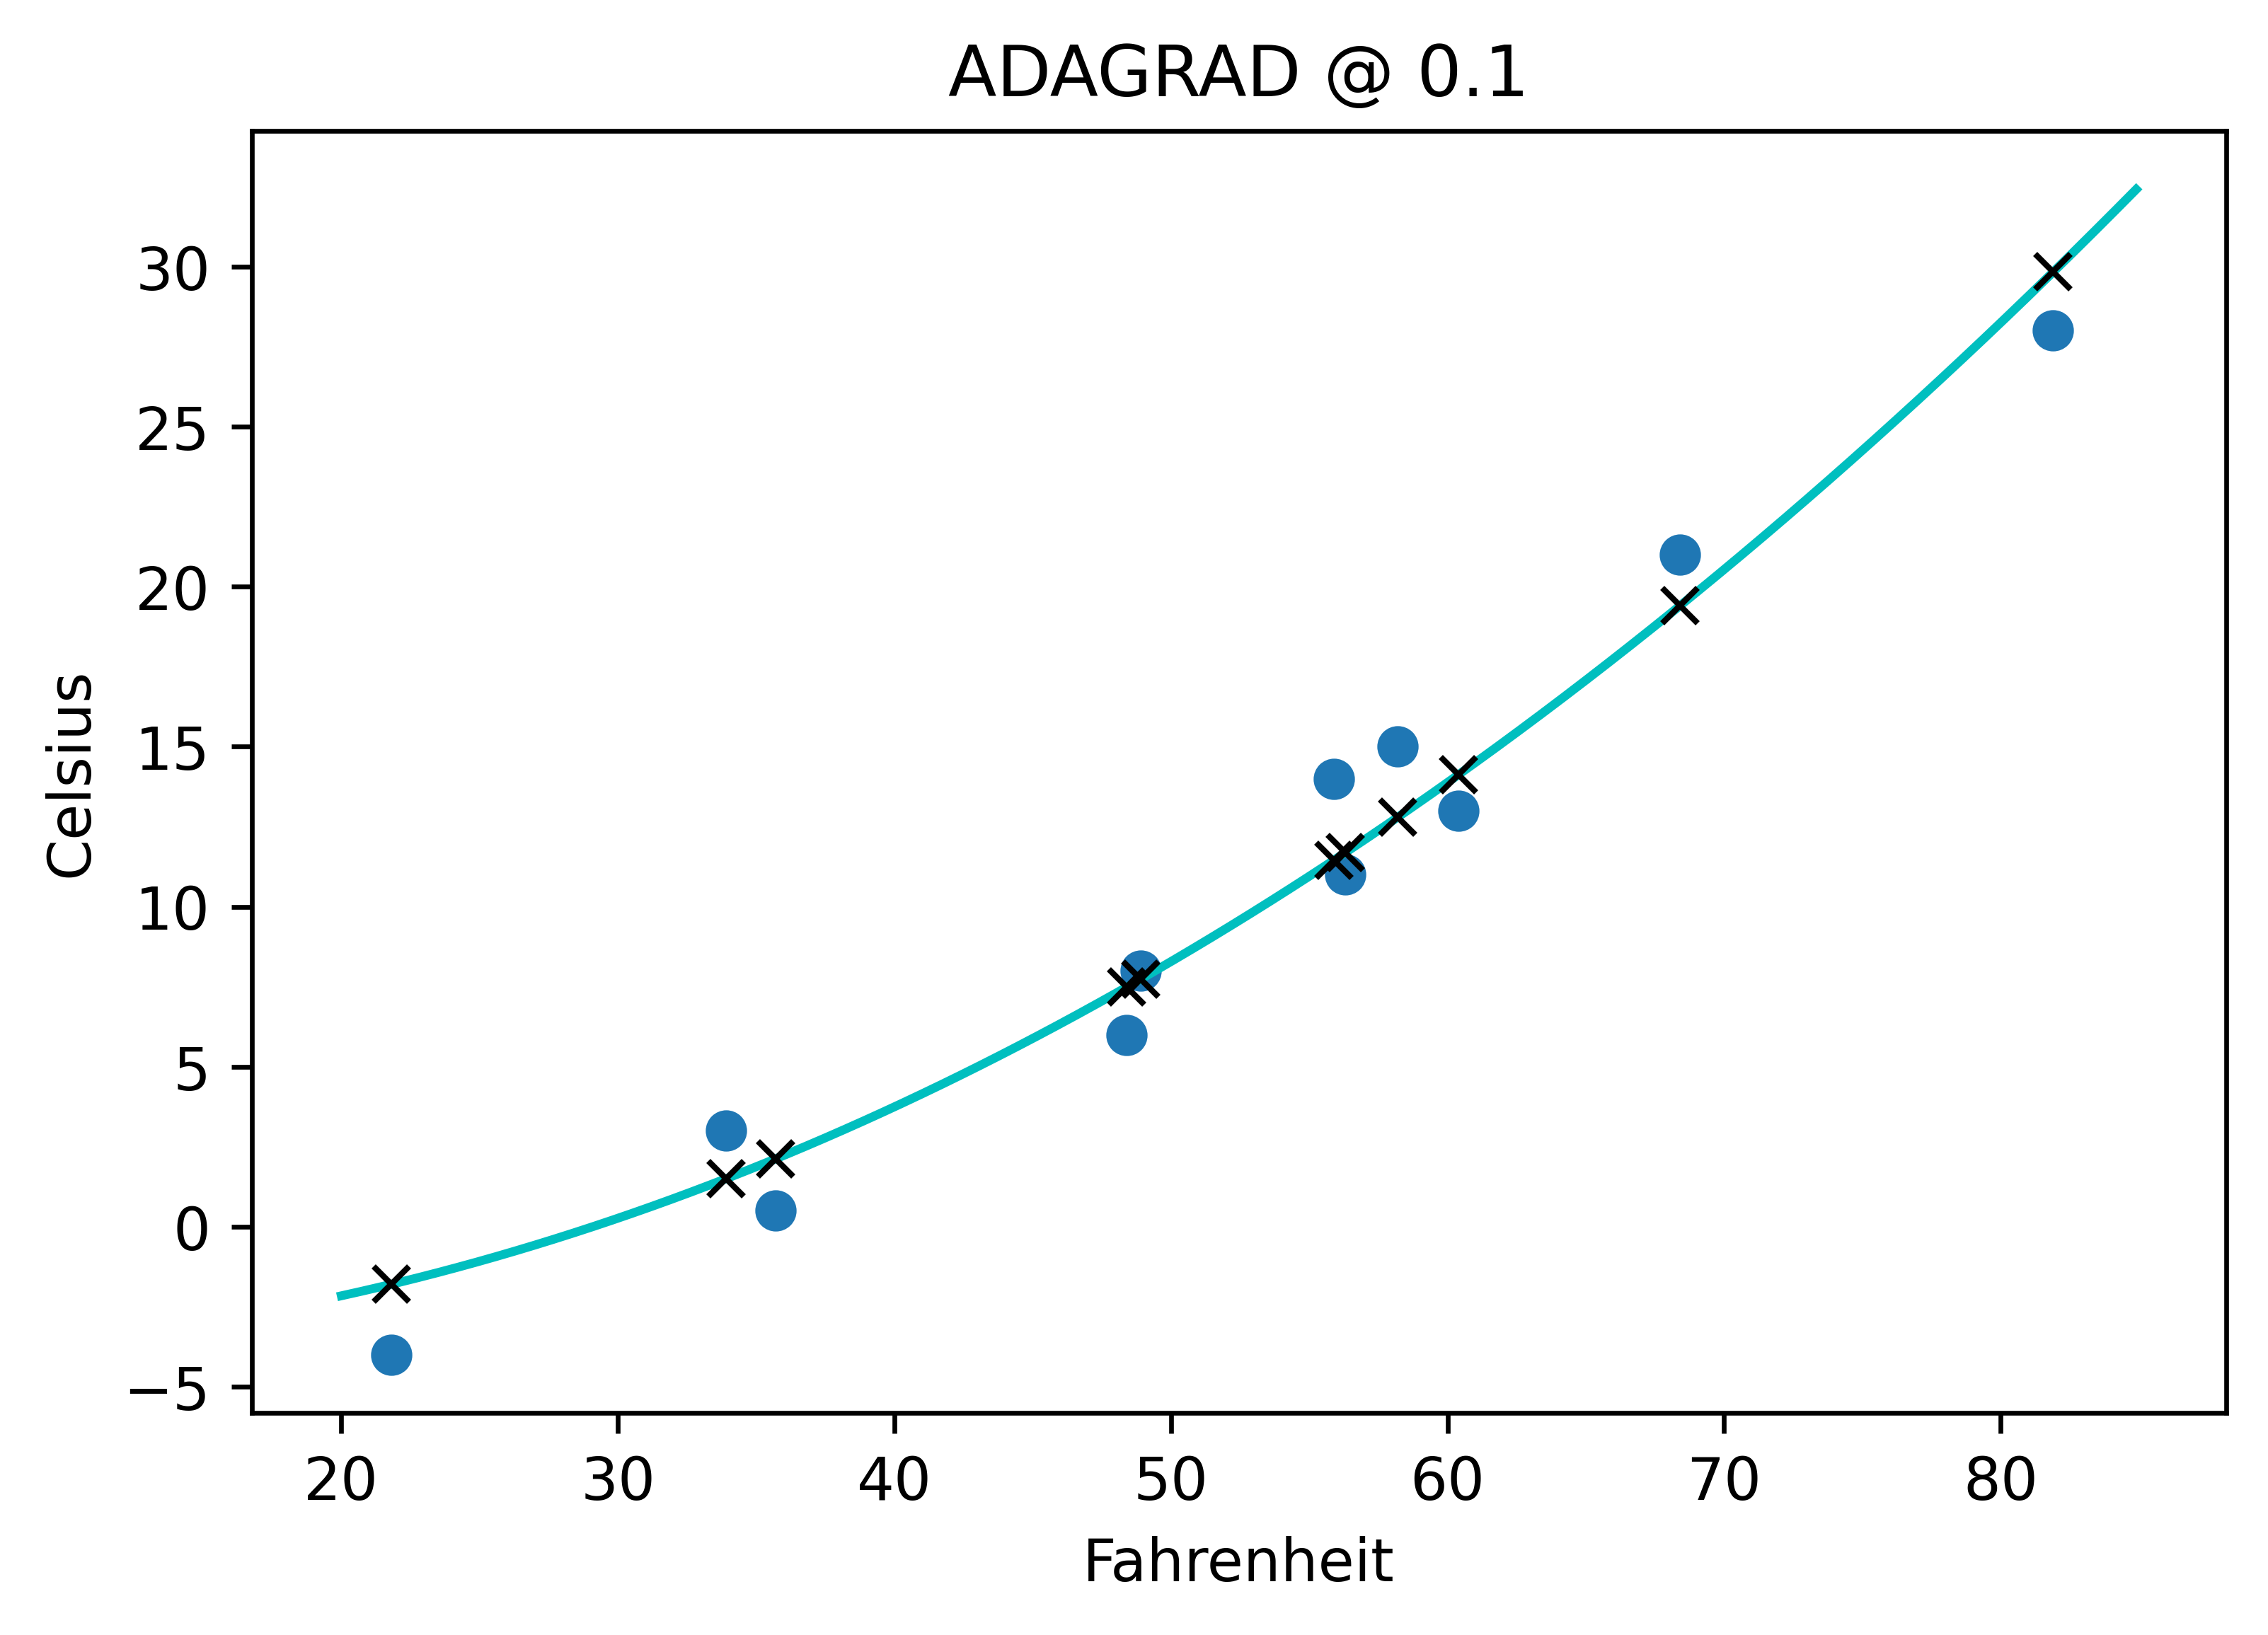

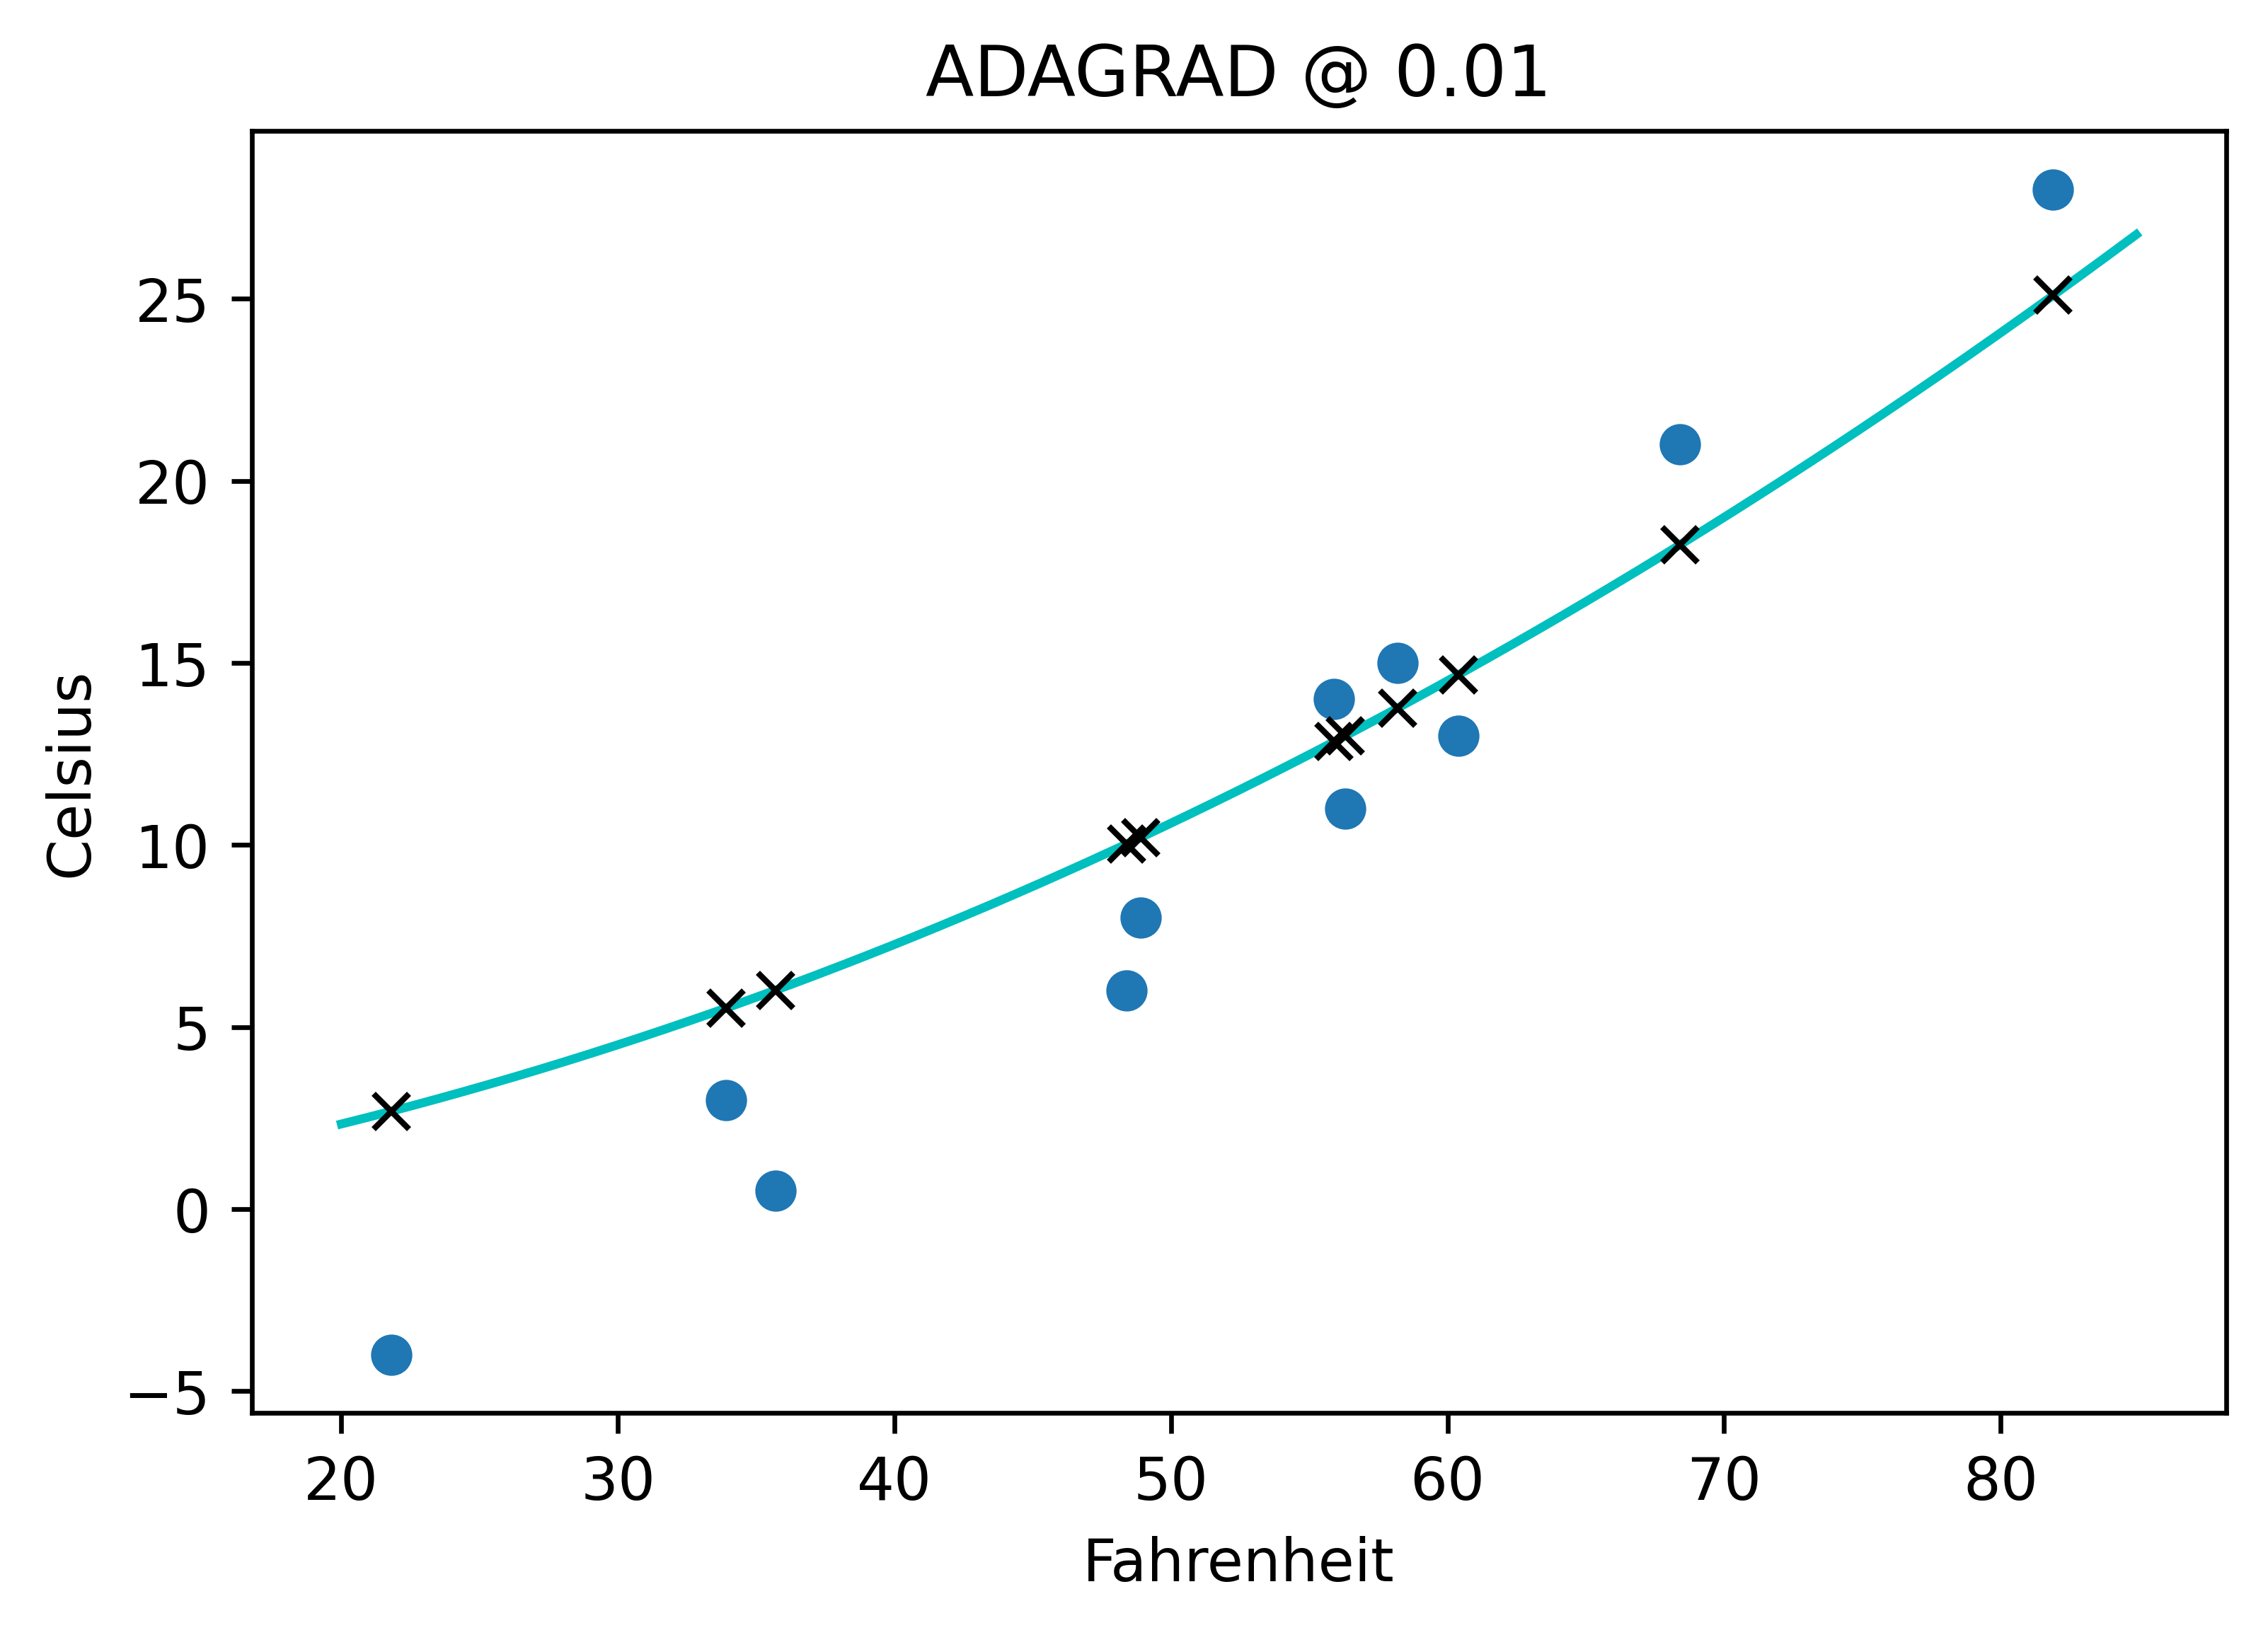

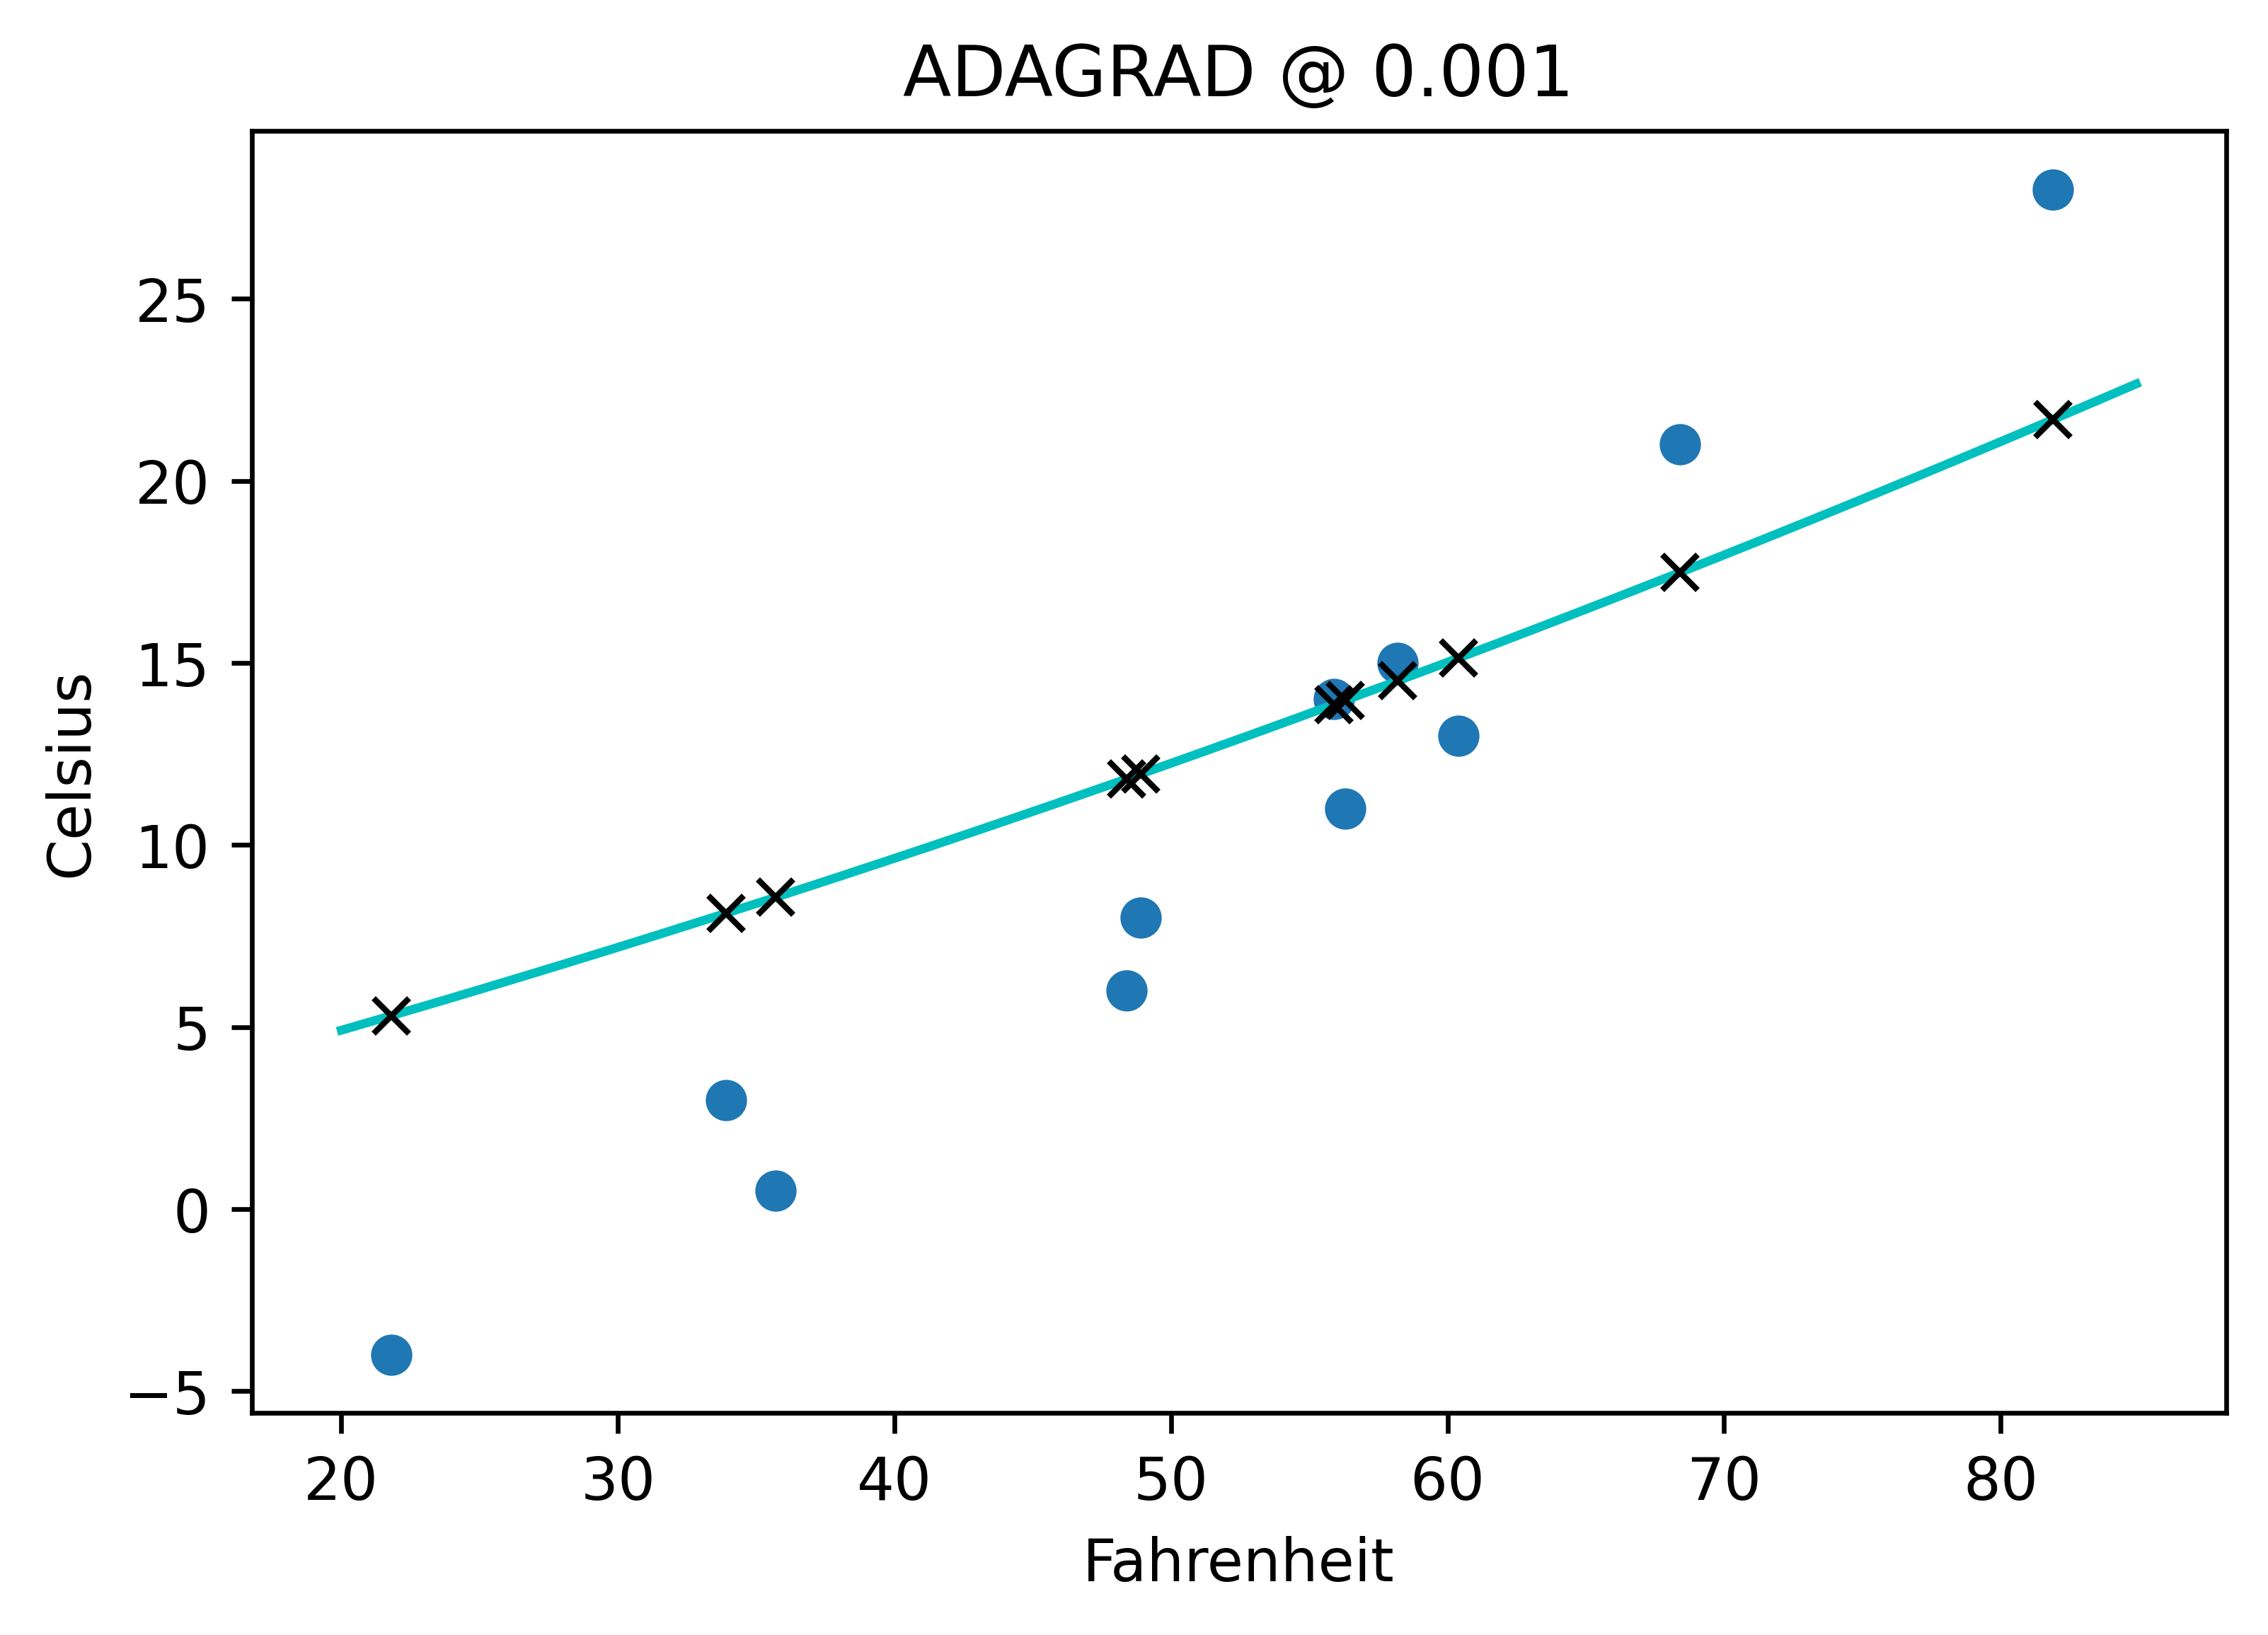

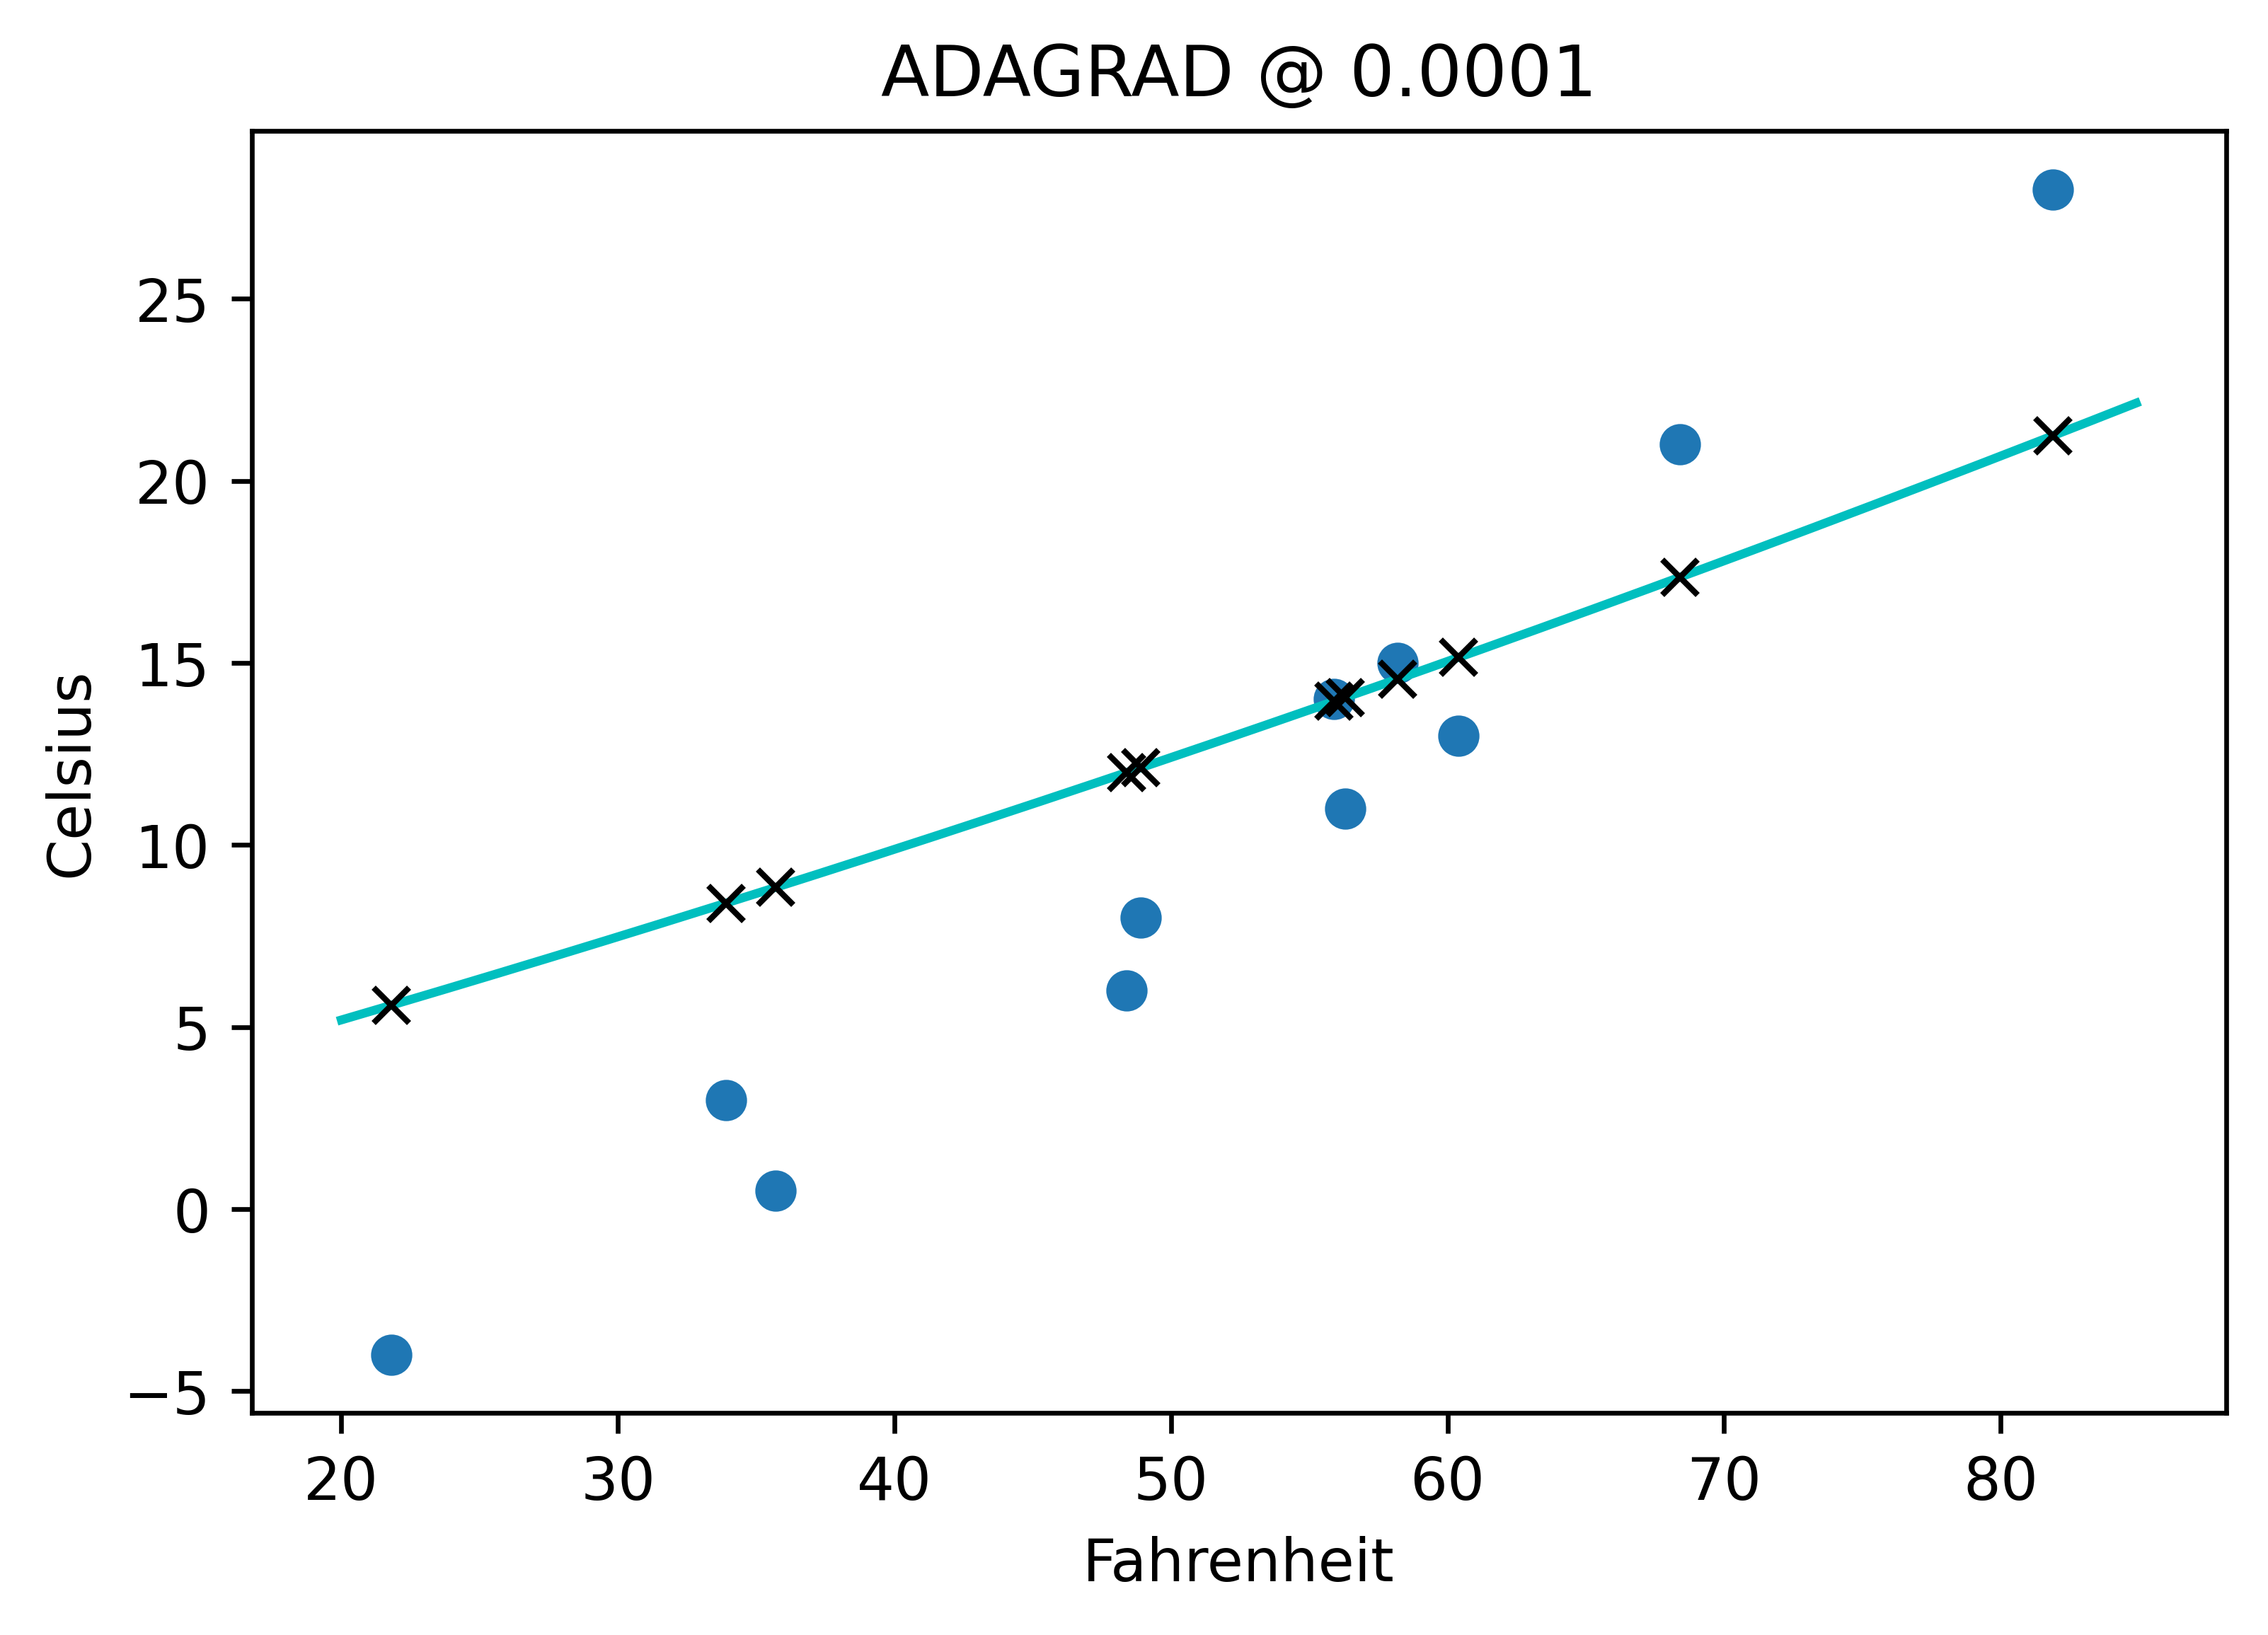

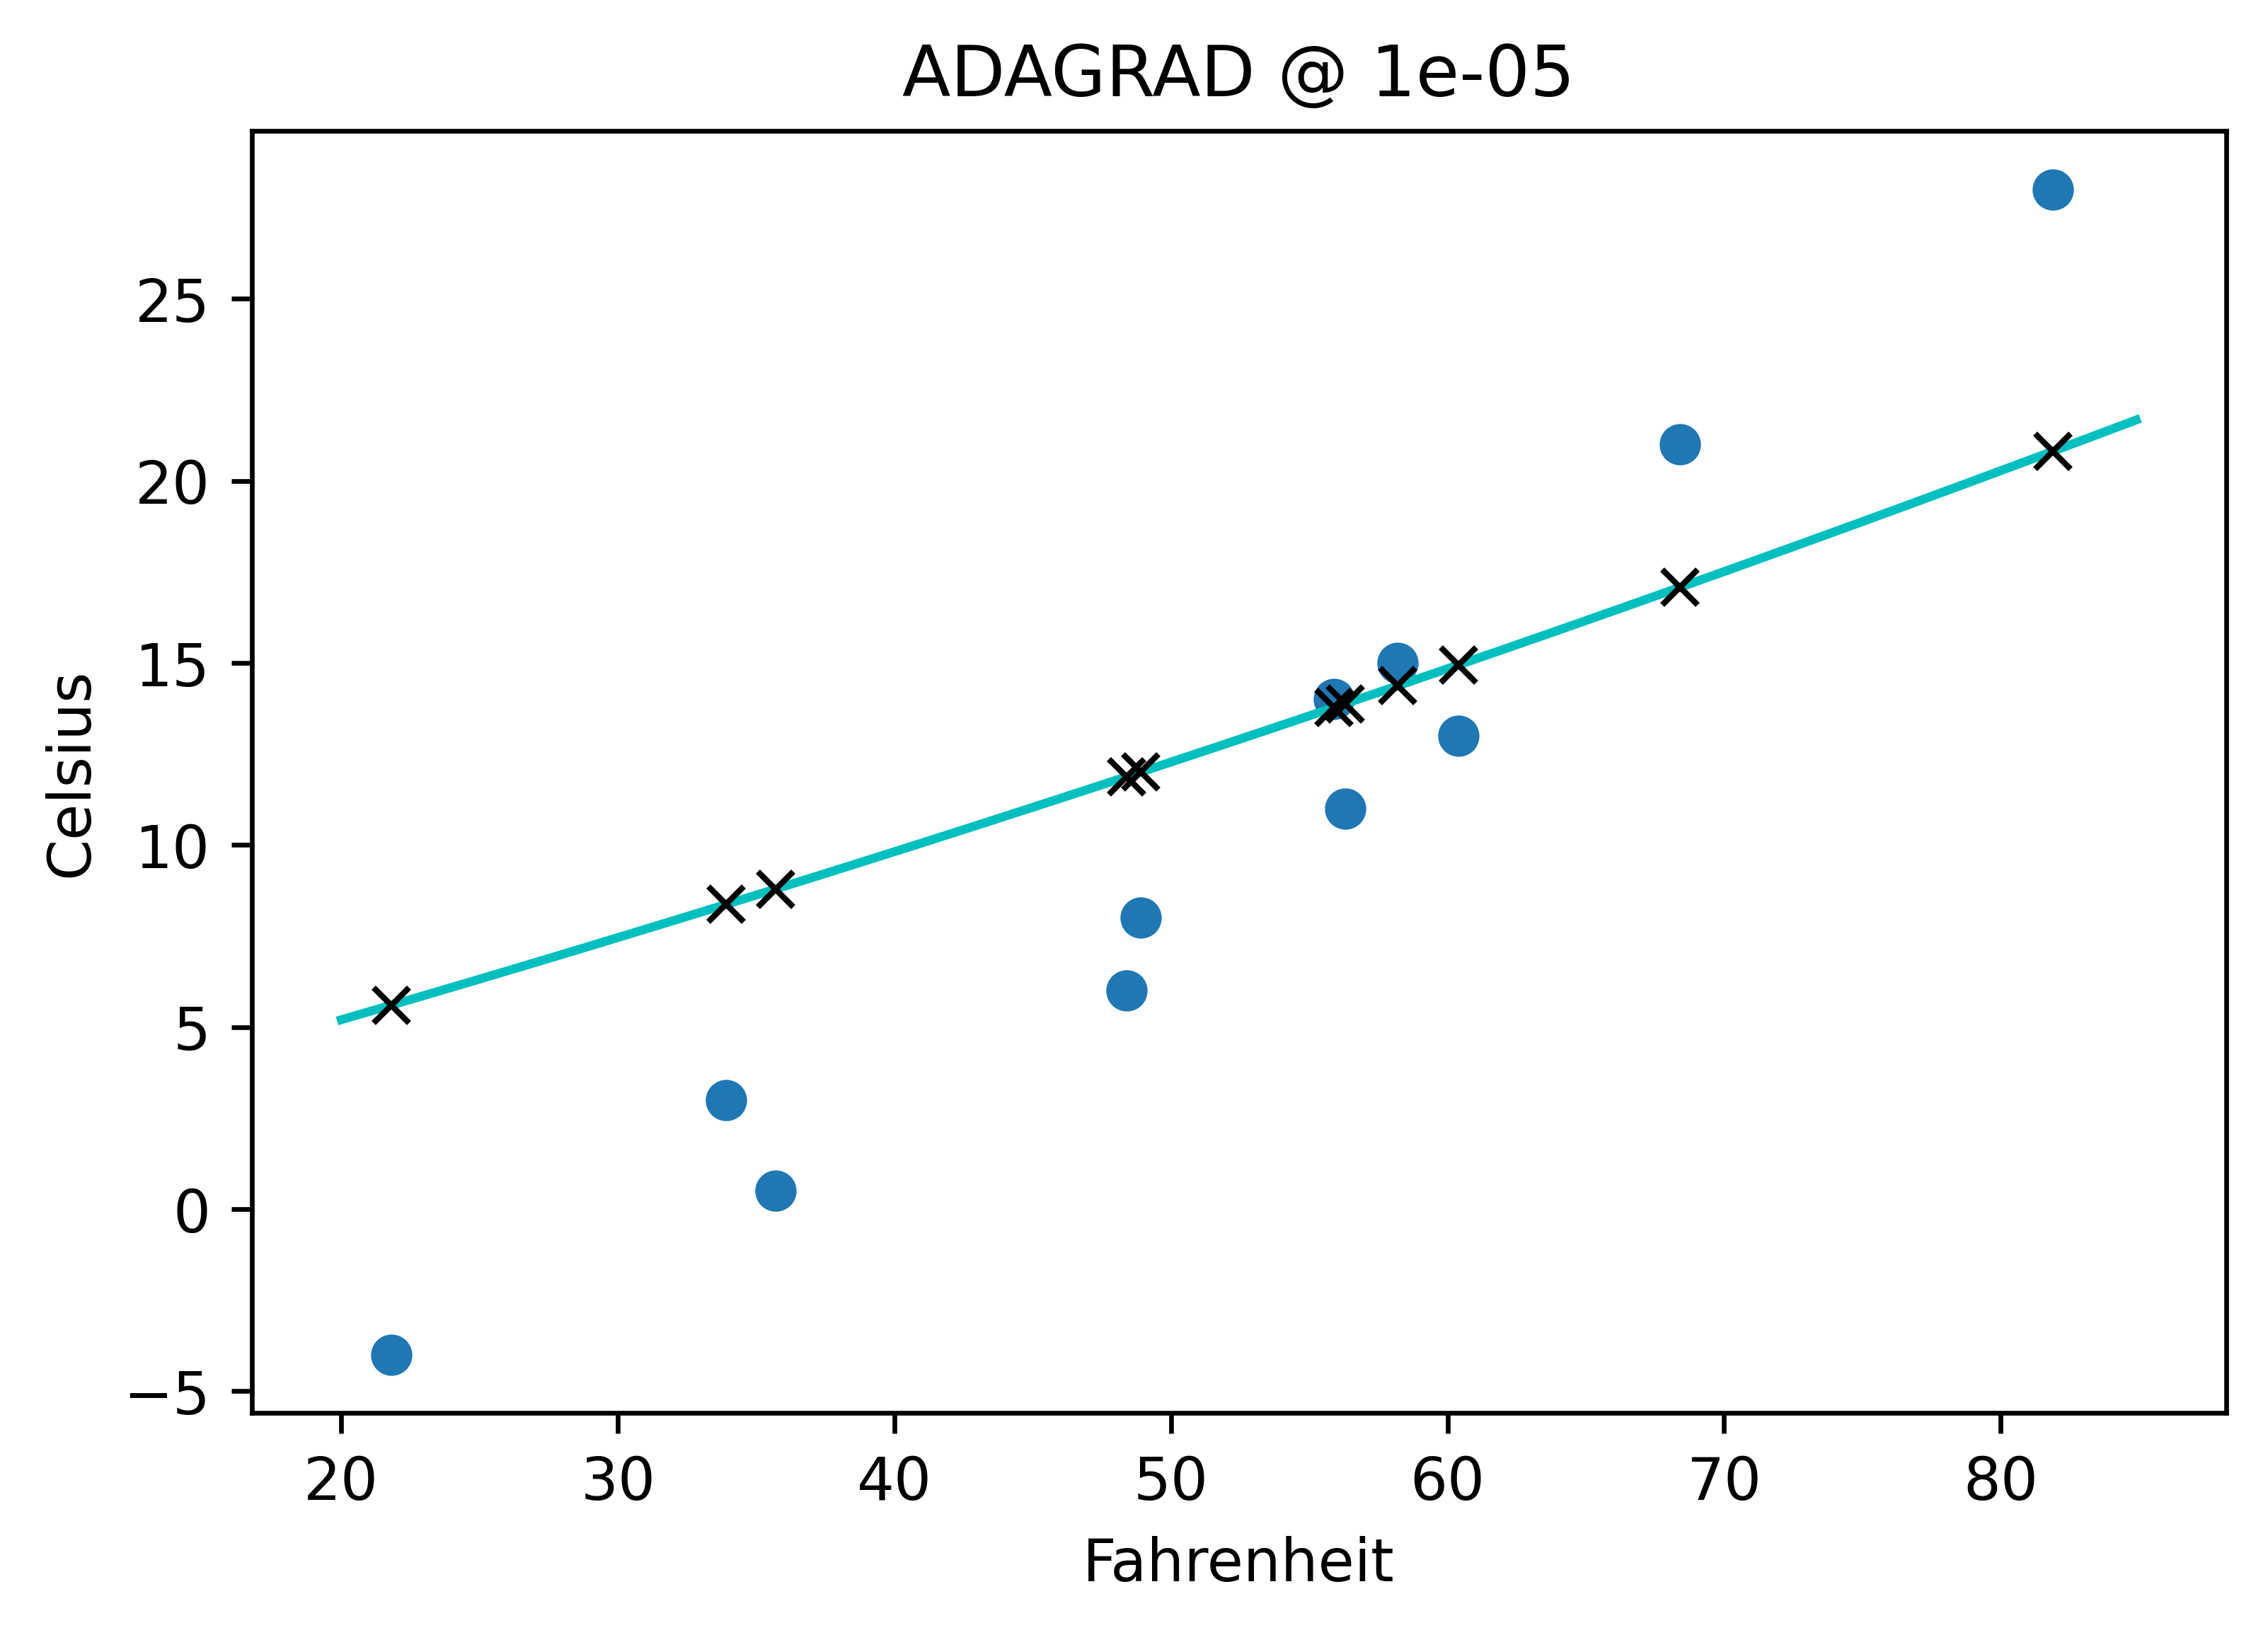

In [18]:
for rate in rates_to_learn_at:
    print(f"Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.Adagrad([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"ADAGRAD @ {rate}")
    
    print('\n'+"--"*30+'\n')

### ASGD

Learning rate is 0.1 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.01 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 2000, Loss nan
    Epoch 2500, Loss nan
    Epoch 3000, Loss nan
    Epoch 3500, Loss nan
    Epoch 4000, Loss nan
    Epoch 4500, Loss nan
    Epoch 5000, Loss nan
Final Paramaters: tensor([nan, nan, nan], requires_grad=True)

------------------------------------------------------------

Learning rate is 0.001 :
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
    Epoch 500, Loss nan
    Epoch 1000, Loss nan
    Epoch 1500, Loss nan
    Epoch 200

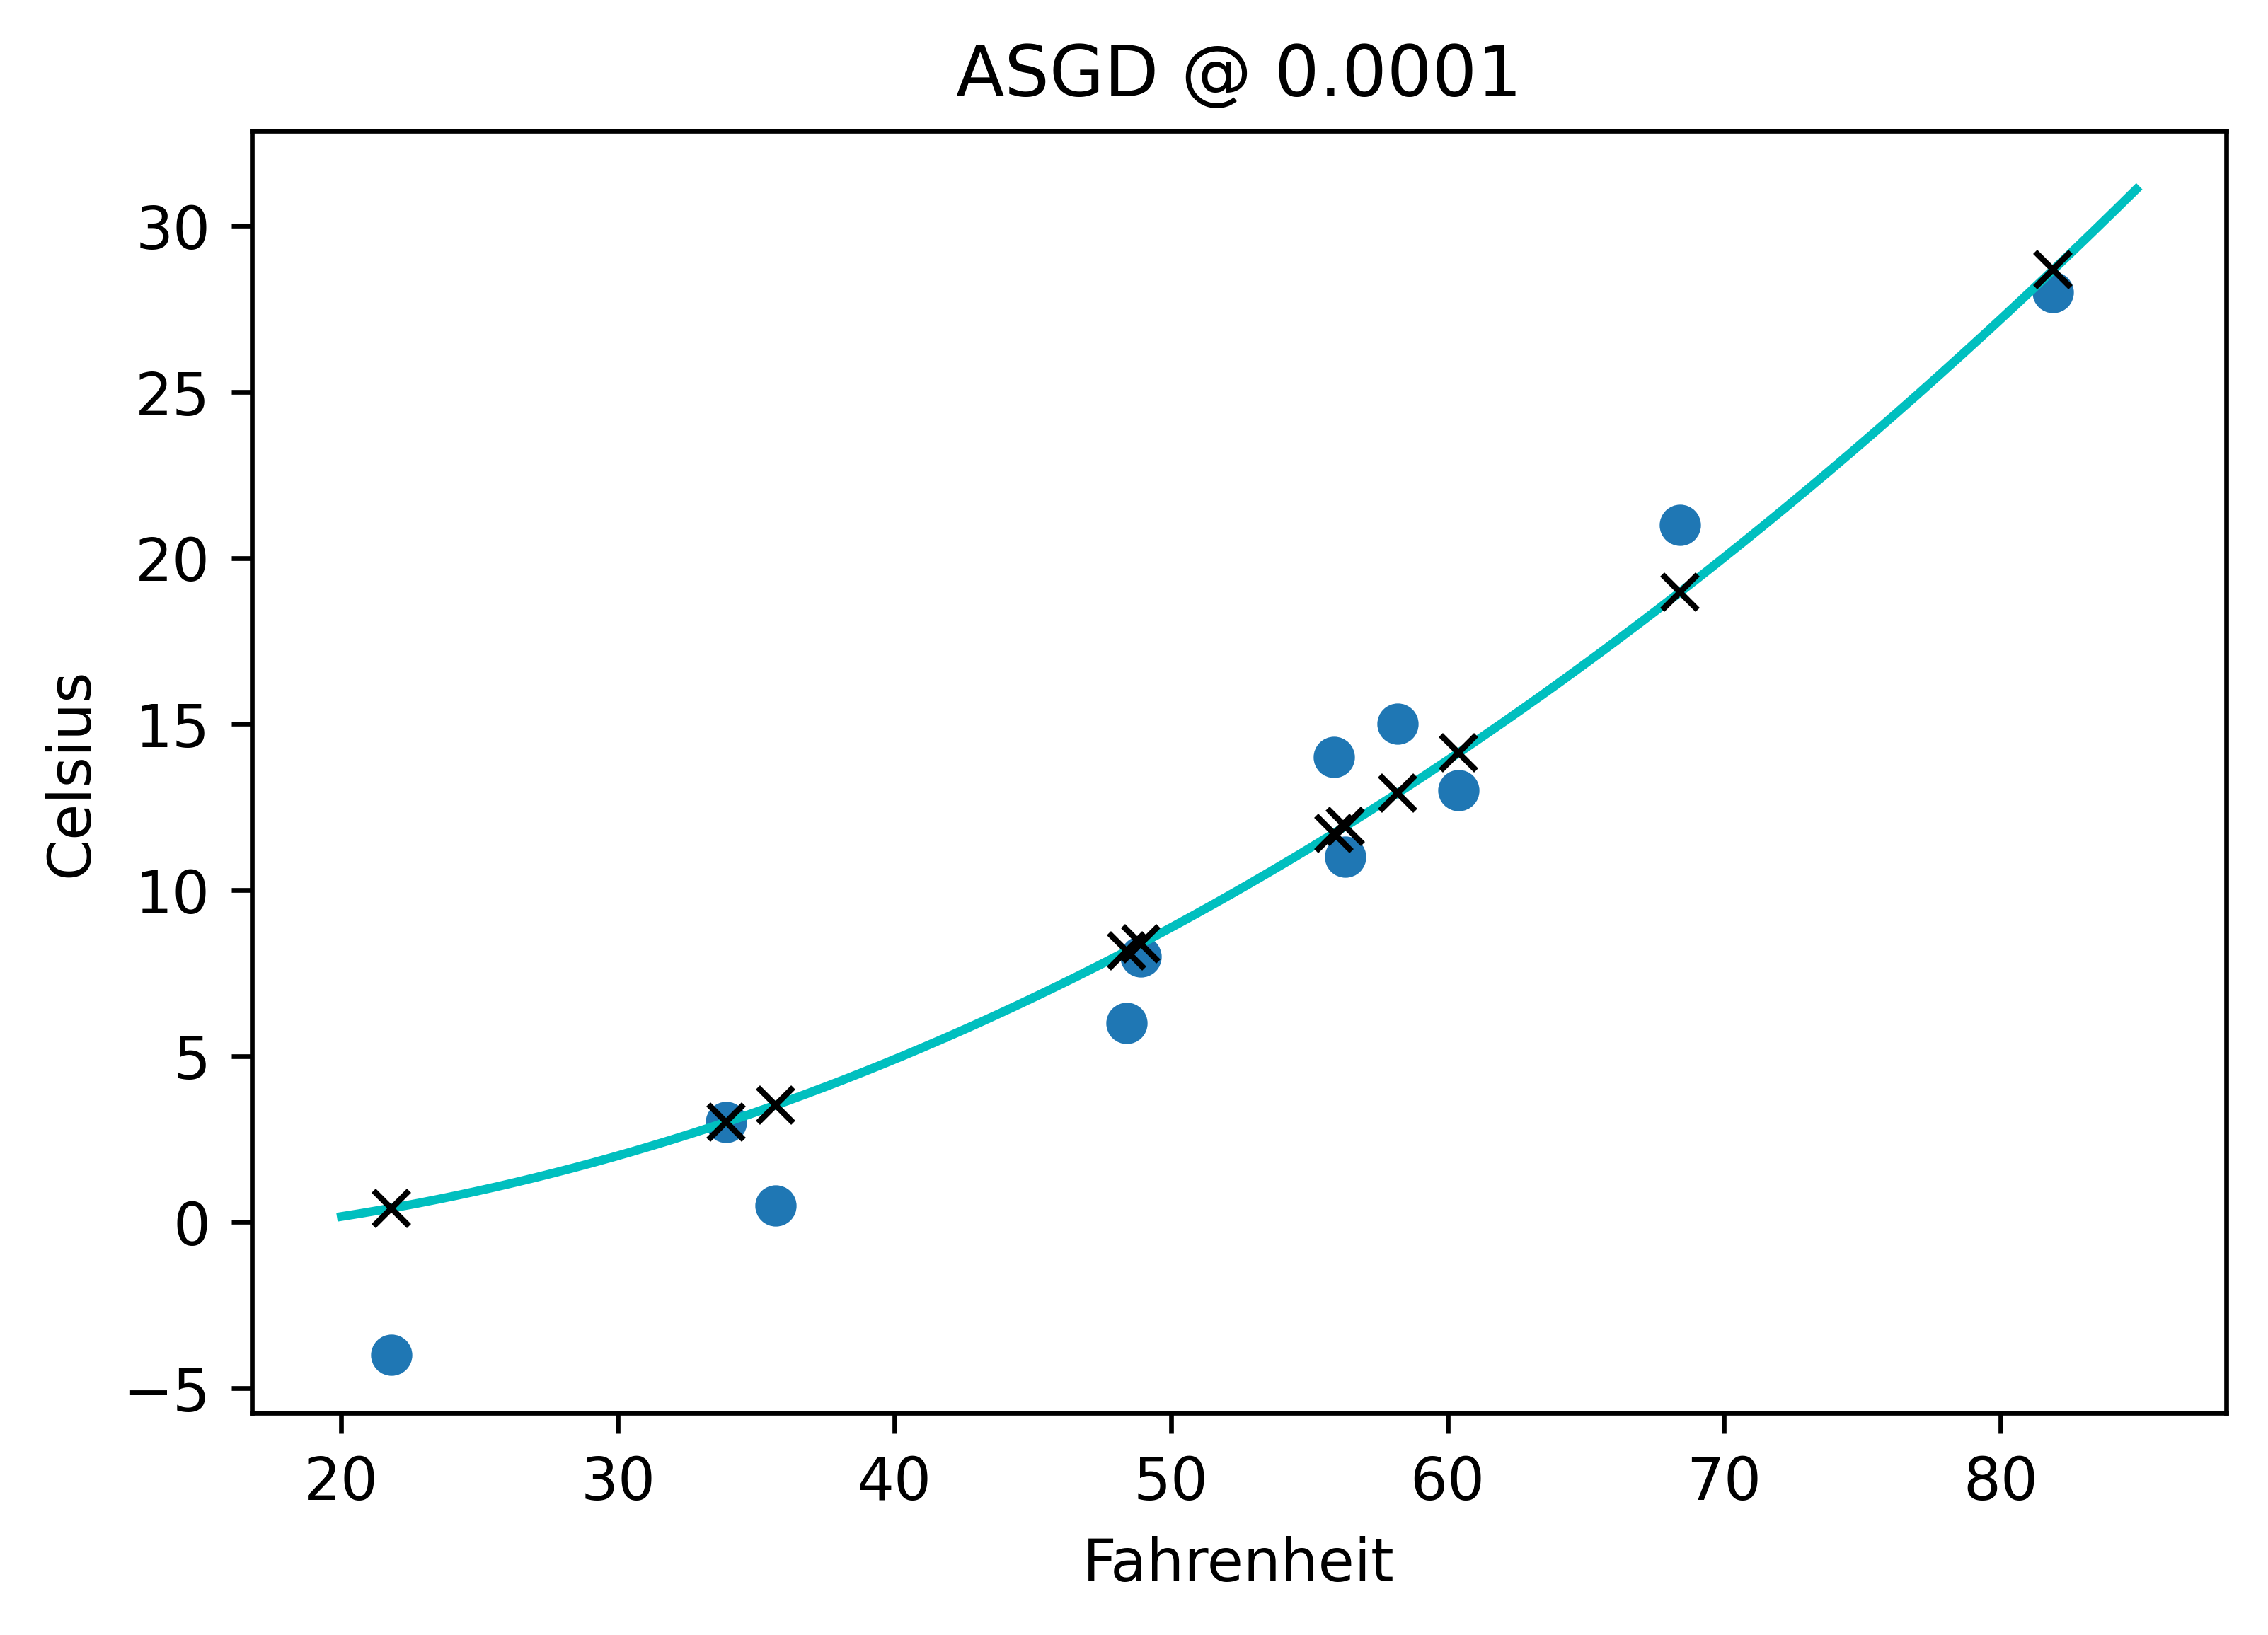

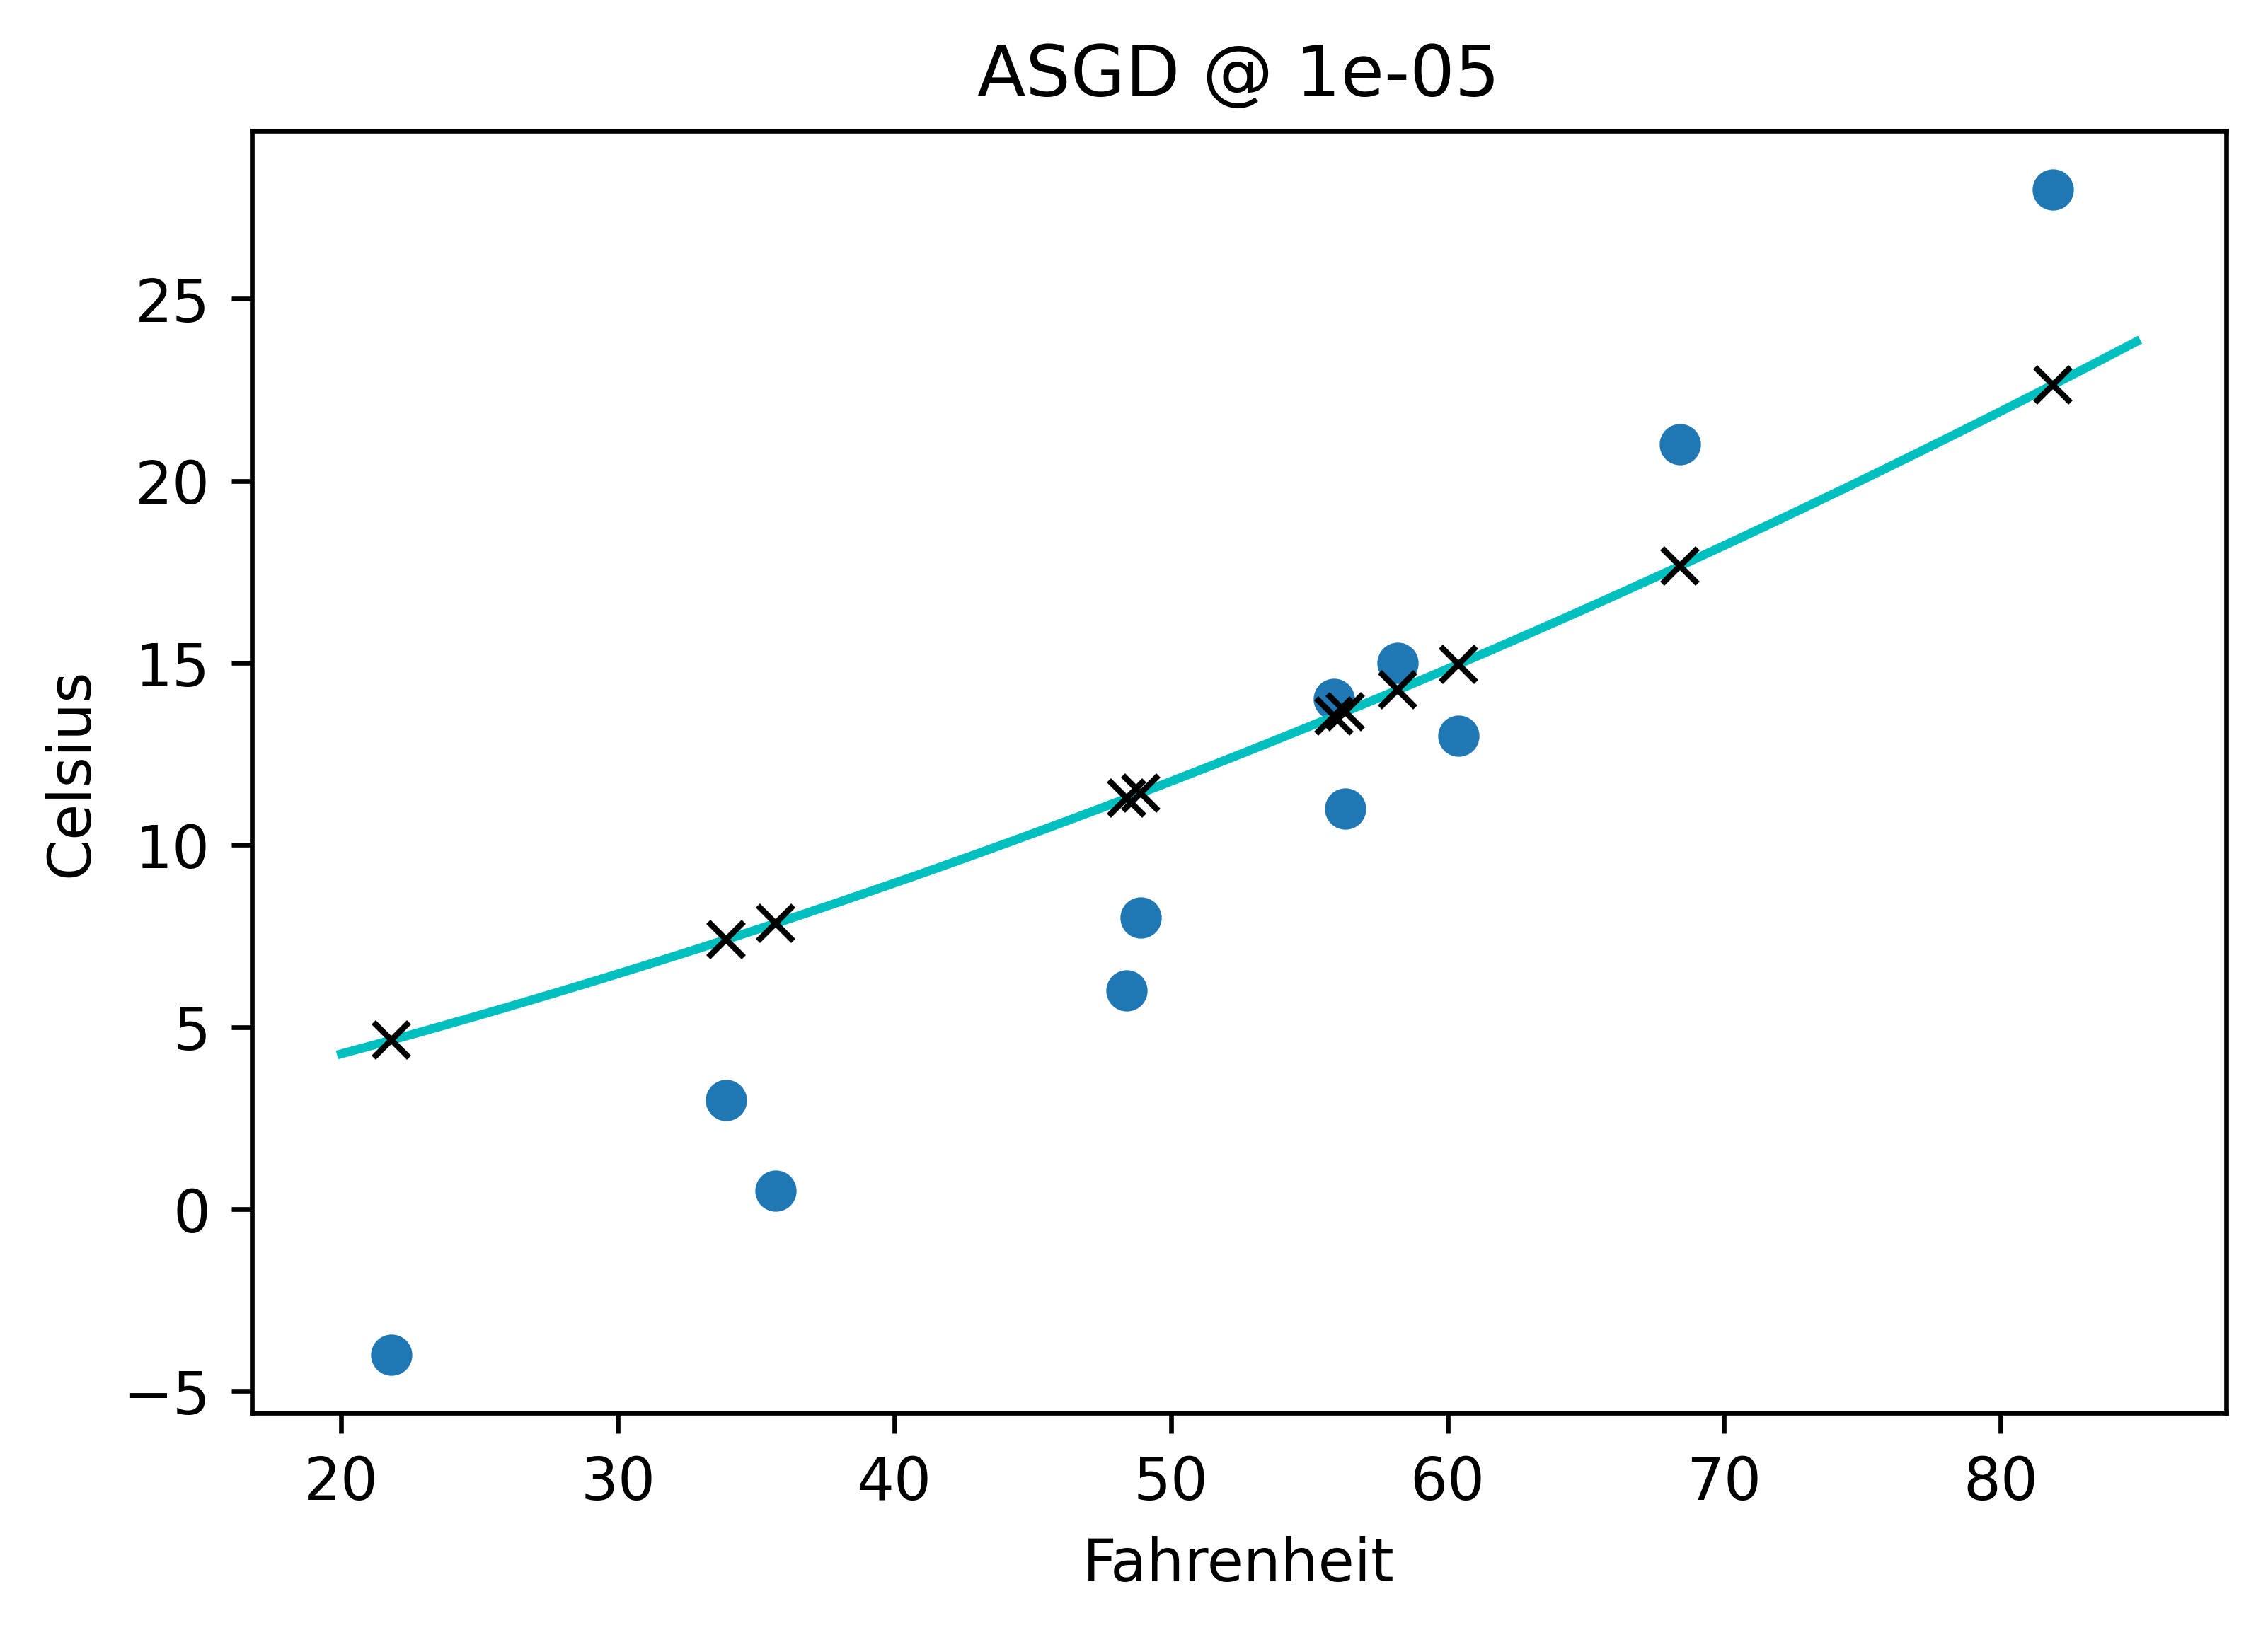

In [19]:
for rate in rates_to_learn_at:
    print(f"Learning rate is {rate} :\n"+"/\\"*15)
    
    params = torch.tensor(initial_paramaters, requires_grad=True)
    learning_rate = rate
    optimizer = optim.ASGD([params], lr=learning_rate) 

    training_loop(
        n_epochs = 5000, 
        optimizer = optimizer,
        params = params, 
        t_u = t_un,
        t_c = t_c)
    
    print(f"Final Paramaters: {params}")
    
    if not (True in torch.isnan(params)):
        graph_temp(model, params, t_u, t_c, f"ASGD @ {rate}")
    
    print('\n'+"--"*30+'\n')